In [ ]:
# Set a fixed random seed
import random
random.seed(42)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import itertools
import collections
import time
import math
import json
import pathlib
import typing
import os # Import os for directory creation and checking memory

# Create folders
pathlib.Path('outputs/').mkdir(parents=True, exist_ok=True)
pathlib.Path('figures/').mkdir(parents=True, exist_ok=True)
pathlib.Path('logs/').mkdir(parents=True, exist_ok=True)

# Define a small helper Timer context manager for profiling
class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end_time = time.time()
        self.duration = self.end_time - self.start_time
        print(f"Timer elapsed: {self.duration:.4f} seconds")

# Define a set_num_threads function
def set_num_threads(n_threads):
    """Sets the number of threads for BLAS libraries."""
    os.environ["OMP_NUM_THREADS"] = str(n_threads)
    os.environ["OPENBLAS_NUM_THREADS"] = str(n_threads)
    os.environ["MKL_NUM_THREADS"] = str(n_threads)
    os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_threads)
    os.environ["NUMEXPR_NUM_THREADS"] = str(n_threads)
    print(f"Number of threads set to {n_threads}")

# Set number of threads to 1 for reproducibility
set_num_threads(1)

# Set matplotlib defaults
plt.rcParams.update({'font.size': 12})
plt.tight_layout()

# Print versions
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NetworkX version: {nx.__version__}")

# Confirm available RAM (using shell command for simplicity)
print("\nAvailable RAM:")
!free -h

# Confirm current working directory
print(f"\nCurrent working directory: {os.getcwd()}")

Number of threads set to 1
NumPy version: 2.0.2
Pandas version: 2.2.2
NetworkX version: 3.5

Available RAM:
               total        used        free      shared  buff/cache   available
Mem:            12Gi       817Mi       9.0Gi       1.0Mi       2.9Gi        11Gi
Swap:             0B          0B          0B

Current working directory: /content


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from dataclasses import dataclass
import os

# Define the Problem dataclass
@dataclass
class Problem:
    coords: np.ndarray # Added coords back to the dataclass
    demand: np.ndarray
    ready: np.ndarray
    due: np.ndarray
    service: np.ndarray
    capacity: int
    max_vehicles: int
    n: int
    depot_id: int

# Load the data from the text file
file_path = '/content/c101.txt'

# Read the header to get capacity and max_vehicles
with open(file_path, 'r') as f:
    # Read lines until the line containing the number of vehicles and capacity
    header_lines = []
    for _ in range(10): # Read up to 10 lines to be safe
        line = next(f)
        header_lines.append(line)
        # Assuming the line with number of vehicles and capacity is the one with two numbers
        parts = line.split()
        numeric_parts = [p for p in parts if p.isdigit()]
        if len(numeric_parts) >= 2:
            max_vehicles = int(numeric_parts[0])
            capacity = int(numeric_parts[1])
            break # Found the line, stop reading header


# Read the data lines, skipping the header (skiprows=9 seems correct based on the format)
data_df = pd.read_csv(file_path, skiprows=9, sep=r'\s+', header=None) # Use raw string for separator

# Define column names based on the Solomon C101 format
column_names = ['id', 'x', 'y', 'demand', 'ready', 'due', 'service']
data_df.columns = column_names

# Add 'is_depot' column: True if id is 0, False otherwise
data_df['is_depot'] = data_df['id'] == 0

# Infer service=90 for all non-depot rows if missing
data_df['service'] = data_df.apply(lambda row: 90 if not row['is_depot'] and pd.isna(row['service']) else row['service'], axis=1)

# Convert relevant columns to numpy arrays
coords = data_df[['x', 'y']].to_numpy()
demand = data_df['demand'].to_numpy()
ready = data_df['ready'].to_numpy()
due = data_df['due'].to_numpy()
service = data_df['service'].to_numpy()
depot_id = data_df[data_df['is_depot']].index[0] # Find the index of the depot

# Get the number of customers (excluding the depot)
n = len(data_df) - 1

# Build the Problem dataclass
problem = Problem(
    coords=coords,
    demand=demand,
    ready=ready,
    due=due,
    service=service,
    capacity=capacity,
    max_vehicles=max_vehicles,
    n=n,
    depot_id=depot_id
)

# Validate data
assert coords.shape == (len(data_df), 2), "Coords shape mismatch"
assert demand.shape == (len(data_df),), "Demand shape mismatch"
assert ready.shape == (len(data_df),), "Ready shape mismatch"
assert due.shape == (len(data_df),), "Due shape mismatch"
assert service.shape == (len(data_df),), "Service shape mismatch"
assert not data_df.isnull().any().any(), "NaN values found in DataFrame"
assert (data_df['ready'] <= data_df['due']).all(), "Ready time is not less than or equal to due time for all customers"

# Print a short summary
print(f"Number of customers (excluding depot): {problem.n}")
print(f"Vehicle capacity: {problem.capacity}")
print(f"Maximum vehicles: {problem.max_vehicles}")
print(f"Time window of depot: [{problem.ready[problem.depot_id]}, {problem.due[problem.depot_id]}]")

# Save a cleaned CSV copy
output_path = 'outputs/c101_clean.csv'
data_df.to_csv(output_path, index=False)
print(f"\nCleaned data saved to {output_path}")

Number of customers (excluding depot): 100
Vehicle capacity: 200
Maximum vehicles: 25
Time window of depot: [0, 1236]

Cleaned data saved to outputs/c101_clean.csv


In [ ]:
# Prompt 3 (self-healing): rebuilds df/problem if missing, then computes distances + correct time primitives
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import json, math

# ---------- Rebuild df / problem if needed ----------
if "df" not in globals():
    if Path("outputs/c101_clean.csv").exists():
        df = pd.read_csv("outputs/c101_clean.csv")
    elif Path("/content/c101.txt").exists():
        # minimal inline parser fallback (very compact): rely on cleaned csv if possible
        raise RuntimeError("df not found and cleaned CSV missing. Please re-run Prompt 2 to parse c101.txt.")
    else:
        raise RuntimeError("df not found and c101.txt not found. Upload c101.txt and re-run Prompt 2.")

# Defaults if header values not in memory
if "CAPACITY" not in globals(): CAPACITY = 200
if "MAX_VEHICLES" not in globals(): MAX_VEHICLES = 25

# Ensure dataclass exists in this cell
@dataclass
class Problem:
    n: int
    depot_id: int
    x: np.ndarray
    y: np.ndarray
    demand: np.ndarray
    ready: np.ndarray
    due: np.ndarray
    service: np.ndarray
    capacity: int
    max_vehicles: int

def build_problem(df: pd.DataFrame, capacity: int, max_vehicles: int) -> Problem:
    d = df.sort_values("id").reset_index(drop=True)
    depot_id = int(d.loc[d["is_depot"], "id"].iloc[0]) if "is_depot" in d.columns else 0
    return Problem(
        n=d.shape[0],
        depot_id=depot_id,
        x=d["x"].to_numpy(np.float32),
        y=d["y"].to_numpy(np.float32),
        demand=d["demand"].to_numpy(np.int32),
        ready=d["ready"].to_numpy(np.float32),
        due=d["due"].to_numpy(np.float32),
        service=d["service"].to_numpy(np.float32) if "service" in d.columns else np.where(d["id"].to_numpy()==0, 0.0, 90.0).astype(np.float32),
        capacity=int(capacity),
        max_vehicles=int(max_vehicles),
    )

# (Re)create problem if missing or malformed
needs_rebuild = ("problem" not in globals()) or (not hasattr(globals()["problem"], "x"))
if needs_rebuild:
    problem = build_problem(df, CAPACITY, MAX_VEHICLES)

# ---------- Distances ----------
coords = np.stack([problem.x, problem.y], axis=1).astype(np.float32)
n = problem.n

D = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=2).astype(np.float32)
# Normalize distances to ~[0,1]
Dmax = float(D.max())
# exclude zeros on diagonal when computing min>0
positive = D[D > 0]
Dmin = float(positive.min()) if positive.size else 0.0
Dhat = (D - Dmin) / (Dmax - Dmin + 1e-9)
np.fill_diagonal(Dhat, 0.0)

def travel_time(i, j, speed=1.0):
    return D[i, j] / speed

def earliest_arrival_with_wait(prev_arr_i, i, j, speed=1.0):
    """
    Compute times for leg i->j:
      - start_service_i = max(prev_arr_i, ready_i)
      - depart_i = start_service_i + service_i
      - raw_arrival = depart_i + travel(i,j)
      - early_wait = max(0, ready_j - raw_arrival)
      - arrival = raw_arrival + early_wait
      - lateness = max(0, arrival - due_j)
    Returns dict with those fields.
    """
    start_service_i = max(float(prev_arr_i), float(problem.ready[i]))
    depart_i = start_service_i + float(problem.service[i])
    raw_arrival = depart_i + travel_time(i, j, speed)
    early_wait = max(0.0, float(problem.ready[j]) - raw_arrival)
    arrival = raw_arrival + early_wait
    lateness = max(0.0, arrival - float(problem.due[j]))
    return {
        "start_service_i": float(start_service_i),
        "depart_i": float(depart_i),
        "raw_arrival": float(raw_arrival),
        "early_wait": float(early_wait),
        "arrival": float(arrival),
        "lateness": float(lateness),
    }

def compute_slack(i, j, prev_arr_i):
    info = earliest_arrival_with_wait(prev_arr_i, i, j)
    return info["early_wait"], info["lateness"], info

# ---------- Sanity prints ----------
print("Distance Matrix D (first 5x5):")
print(np.round(D[:5, :5], 6))
print("\nNormalized Distance Matrix Dhat (first 5x5):")
print(np.round(Dhat[:5, :5], 8))

print("\n--- Unit Tests (fixed) ---")
tests = [
    (0, 1, 0.0),
    (1, 5, float(problem.ready[1])),
    (10, 20, float(problem.ready[10])),
    (3, 0, float(problem.ready[3])),
]
for (i, j, prev) in tests:
    ew, late, info = compute_slack(i, j, prev)
    print(f"\nArc: ({i} -> {j})")
    print(f"  Prev arrival at {i}: {prev:.2f}")
    print(f"  Service at {i}: {problem.service[i]:.2f}")
    print(f"  Travel(i->j): {D[i,j]:.2f}")
    print(f"  RAW arrival at {j}: {info['raw_arrival']:.2f}")
    print(f"  early_wait: {ew:.2f}")
    print(f"  ARRIVAL: {info['arrival']:.2f}")
    print(f"  TW[{j}]: [{problem.ready[j]:.2f}, {problem.due[j]:.2f}]")
    print(f"  Lateness: {late:.2f}")

# Quick assertion to ensure attrs exist
assert hasattr(problem, "x") and hasattr(problem, "y") and hasattr(problem, "service"), "Problem object malformed."

print("\nOK: problem + distance/time primitives ready.")


Distance Matrix D (first 5x5):
[[ 0.       18.681541 20.615528 16.124516 18.110771]
 [18.681541  0.        2.        3.605551  3.      ]
 [20.615528  2.        0.        5.        3.605551]
 [16.124516  3.605551  5.        0.        2.      ]
 [18.110771  3.        3.605551  2.        0.      ]]

Normalized Distance Matrix Dhat (first 5x5):
[[0.         0.18577552 0.20609543 0.15890948 0.17977858]
 [0.18577552 0.         0.01050675 0.02737587 0.0210135 ]
 [0.20609543 0.01050675 0.         0.042027   0.02737587]
 [0.15890948 0.02737587 0.042027   0.         0.01050675]
 [0.17977858 0.0210135  0.02737587 0.01050675 0.        ]]

--- Unit Tests (fixed) ---

Arc: (0 -> 1)
  Prev arrival at 0: 0.00
  Service at 0: 0.00
  Travel(i->j): 18.68
  RAW arrival at 1: 18.68
  early_wait: 893.32
  ARRIVAL: 912.00
  TW[1]: [912.00, 967.00]
  Lateness: 0.00

Arc: (1 -> 5)
  Prev arrival at 1: 912.00
  Service at 1: 90.00
  Travel(i->j): 4.24
  RAW arrival at 5: 1006.24
  early_wait: 0.00
  ARRIVAL: 10

In [ ]:
# Prompt 4 — Dual potential & temporal cost (uses corrected 'lateness' + 'early_wait')

import numpy as np
import json
from pathlib import Path

# ---- Hyperparameters (tweakable) ----
lambda_dist = 0.5   # weight on normalized distance (0..1)
alpha       = 1.0   # weight on lateness penalty
beta        = 1.0   # weight on early-wait penalty
delta       = 45.0  # minutes; target early buffer (see mode below)

# How to penalize early_wait:
#   "buffer_target"  -> penalty if early_wait < delta (encourages a safety buffer before ready time)
#   "too_early"      -> penalty if early_wait is large (discourages arriving excessively early and waiting)
early_penalty_mode = "buffer_target"   # change to "too_early" if desired

n = problem.n

# We will compute early_wait and lateness for each arc i->j assuming we
# begin service at node i no earlier than its ready time (state-free potential).
early_wait_mat = np.zeros((n, n), dtype=np.float32)
lateness_mat   = np.zeros((n, n), dtype=np.float32)

for i in range(n):
    # Use earliest permissible time to start at i
    prev_arr_i = float(problem.ready[i])  # earliest arrival allowed by window
    for j in range(n):
        if i == j:
            early_wait_mat[i, j] = 0.0
            lateness_mat[i, j]   = 0.0
            continue
        info = earliest_arrival_with_wait(prev_arr_i, i, j)
        early_wait_mat[i, j] = info["early_wait"]
        lateness_mat[i, j]   = info["lateness"]

# Normalize lateness to [0,1] over all arcs (if all zero, keep zeros)
max_late = float(lateness_mat.max())
late_norm = (lateness_mat / (max_late + 1e-9)).astype(np.float32)

# Early-wait penalty
if early_penalty_mode == "buffer_target":
    # Encourage having at least 'delta' minutes of buffer (no penalty once early_wait >= delta)
    early_pen = np.maximum(0.0, delta - early_wait_mat) / (delta + 1e-9)
elif early_penalty_mode == "too_early":
    # Discourage arriving excessively early (penalty grows with early_wait up to delta)
    early_pen = np.minimum(1.0, early_wait_mat / (delta + 1e-9))
else:
    raise ValueError("early_penalty_mode must be 'buffer_target' or 'too_early'.")

early_pen = early_pen.astype(np.float32)

# Temporal potential in [0, 2] (before scaling) then re-normalize to [0,1]
tau_raw = alpha * late_norm + beta * early_pen
# Normalize tau_raw to [0,1] (safe if constant)
tau_min, tau_max = float(tau_raw.min()), float(tau_raw.max())
tau_hat = ((tau_raw - tau_min) / (tau_max - tau_min + 1e-9)).astype(np.float32)

# Twinned potential: distance + temporal
# Dhat must be defined in Prompt 3; ensure it exists
if "Dhat" not in globals():
    raise RuntimeError("Dhat not found. Run Prompt 3 before this cell.")

C = (lambda_dist * Dhat + (1.0 - lambda_dist) * tau_hat).astype(np.float32)
np.fill_diagonal(C, 0.0)  # keep self-costs clean

# ---- Diagnostics & persistence ----
stats = {
    "lambda_dist": lambda_dist,
    "alpha": alpha,
    "beta": beta,
    "delta": delta,
    "early_penalty_mode": early_penalty_mode,
    "tau_hat_min": float(tau_hat.min()),
    "tau_hat_mean": float(tau_hat.mean()),
    "tau_hat_max": float(tau_hat.max()),
    "C_min": float(C.min()),
    "C_mean": float(C.mean()),
    "C_max": float(C.max()),
    "max_late_raw": max_late,
    "early_wait_min": float(early_wait_mat.min()),
    "early_wait_mean": float(early_wait_mat.mean()),
    "early_wait_max": float(early_wait_mat.max()),
}

Path("outputs").mkdir(exist_ok=True)
np.save("outputs/early_wait_mat.npy", early_wait_mat)
np.save("outputs/lateness_mat.npy",   lateness_mat)
np.save("outputs/tau_hat.npy",        tau_hat)
np.save("outputs/C.npy",              C)
with open("outputs/potential_stats.json", "w") as f:
    json.dump(stats, f, indent=2)

print("=== Potential Construction Summary ===")
print(json.dumps(stats, indent=2))
print("\nSample tau_hat (5x5):")
print(np.round(tau_hat[:5, :5], 4))
print("\nSample C (5x5):")
print(np.round(C[:5, :5], 4))


=== Potential Construction Summary ===
{
  "lambda_dist": 0.5,
  "alpha": 1.0,
  "beta": 1.0,
  "delta": 45.0,
  "early_penalty_mode": "buffer_target",
  "tau_hat_min": 0.0,
  "tau_hat_mean": 0.4092925190925598,
  "tau_hat_max": 1.0,
  "C_min": 0.0,
  "C_mean": 0.40226927399635315,
  "C_max": 0.8630051612854004,
  "max_late_raw": 1109.31103515625,
  "early_wait_min": 0.0,
  "early_wait_mean": 107.0793685913086,
  "early_wait_max": 1035.9722900390625
}

Sample tau_hat (5x5):
[[0.5    0.     0.     0.     0.    ]
 [0.5    0.5    0.5604 0.8875 0.6005]
 [0.5    0.5    0.5    0.8489 0.5616]
 [0.5    0.     0.     0.5    0.    ]
 [0.5    0.     0.4512 0.8033 0.5   ]]

Sample C (5x5):
[[0.     0.0929 0.103  0.0795 0.0899]
 [0.3429 0.     0.2855 0.4574 0.3108]
 [0.353  0.2553 0.     0.4454 0.2945]
 [0.3295 0.0137 0.021  0.     0.0053]
 [0.3399 0.0105 0.2393 0.4069 0.    ]]


In [ ]:
import numpy as np
tau_hat = np.load("outputs/tau_hat.npy")
np.fill_diagonal(tau_hat, 0.0)
np.save("outputs/tau_hat.npy", tau_hat)


In [ ]:
# Prompt 5 (alternate miner) — enumerate k-cliques of size 3..5 (not just maximal)

import json, itertools
from pathlib import Path
import numpy as np
import networkx as nx

# Preconditions
assert "problem" in globals() and hasattr(problem, "x")
assert "earliest_arrival_with_wait" in globals()
# Rebuild G_temp quickly if needed (or reuse from prior cell)
if "G_temp" not in globals():
    n = problem.n
    customers = [i for i in range(n) if i != problem.depot_id]
    def leg_is_on_time(i, j):
        info = earliest_arrival_with_wait(float(problem.ready[i]), i, j)
        return info["lateness"] <= 1e-6
    G_temp = nx.Graph()
    G_temp.add_nodes_from(customers)
    for i in customers:
        for j in customers:
            if i < j and (leg_is_on_time(i, j) or leg_is_on_time(j, i)):
                G_temp.add_edge(i, j)
    print(f"Rebuilt temporal graph: |V|={G_temp.number_of_nodes()}, |E|={G_temp.number_of_edges()}")

# Enumerate k-cliques directly (can be many; stop early)
MAX_KEPT = 300           # hard cap of saved hypercliques
STOP_AFTER = 50000       # stop scanning after this many candidates
SIZES = {3,4,5}

def sequence_feasible(order):
    current_arrival = float(problem.ready[order[0]])
    for a,b in zip(order, order[1:]):
        info = earliest_arrival_with_wait(current_arrival, a, b)
        if info["lateness"] > 1e-6:
            return False
        current_arrival = info["arrival"]
    return True

def find_any_feasible_order(nodes):
    for perm in itertools.permutations(nodes):
        if sequence_feasible(list(perm)):
            return list(perm)
    return None

kept, kept_orders = [], []
scanned = 0

# enumerate_all_cliques yields increasing sizes; we ignore >5
for clq in nx.enumerate_all_cliques(G_temp):
    L = len(clq)
    if L > 5:
        continue
    if L < 3:
        continue
    scanned += 1
    if scanned > STOP_AFTER:
        break
    if L in SIZES:
        order = find_any_feasible_order(clq)
        if order is not None:
            kept.append(clq)
            kept_orders.append(order)
            if len(kept) >= MAX_KEPT:
                break

print(f"Enumerated candidates scanned: {scanned}")
print(f"Kept hypercliques (size 3–5): {len(kept)} (cap {MAX_KEPT})")

# Save artifacts
Path("outputs").mkdir(exist_ok=True)
with open("outputs/hypercliques.json", "w") as f:
    json.dump(kept, f)
with open("outputs/hypercliques_orders.json", "w") as f:
    json.dump(kept_orders, f)

# Preview
def print_top_hypercliques(kept, kept_orders, top=5):
    m = min(top, len(kept))
    if m == 0:
        print("No 3–5 cliques kept under strict on-time sequencing; that's OK. Continue to Prompt 6.")
        return
    print("\nTop hypercliques (size, nodes) with one feasible order:")
    for idx in range(m):
        nodes = kept[idx]
        order = kept_orders[idx]
        print(f"  {idx+1:>2}. size={len(nodes)} | nodes={nodes} | feasible_order={order}")

print_top_hypercliques(kept, kept_orders)


Enumerated candidates scanned: 302
Kept hypercliques (size 3–5): 300 (cap 300)

Top hypercliques (size, nodes) with one feasible order:
   1. size=3 | nodes=[1, 2, 3] | feasible_order=[3, 2, 1]
   2. size=3 | nodes=[1, 2, 4] | feasible_order=[4, 2, 1]
   3. size=3 | nodes=[1, 2, 5] | feasible_order=[5, 2, 1]
   4. size=3 | nodes=[1, 2, 6] | feasible_order=[6, 2, 1]
   5. size=3 | nodes=[1, 2, 7] | feasible_order=[7, 2, 1]


In [ ]:
# Bind for Prompt 6
import json, numpy as np
hypercliques = kept
hyperclique_orders = kept_orders

# (Optional) diversify: keep up to 200 blocks, reduce near-duplicates by Jaccard similarity
def diversify_hypercliques(hc, max_keep=200, min_jaccard=0.6, seed=42):
    rng = np.random.default_rng(seed)
    order = rng.permutation(len(hc))
    selected, sets = [], []
    for idx in order:
        s = set(hc[idx])
        if all((len(s & t) / len(s | t)) < min_jaccard for t in sets):
            selected.append(hc[idx])
            sets.append(s)
            if len(selected) >= max_keep:
                break
    return selected

# Uncomment to apply diversification (optional)
# hypercliques = diversify_hypercliques(hypercliques, max_keep=200, min_jaccard=0.6)

# Persist (keeps filenames consistent for later steps)
with open("outputs/hypercliques.json", "w") as f:
    json.dump(hypercliques, f)
with open("outputs/hypercliques_orders.json", "w") as f:
    json.dump(hyperclique_orders, f)

len(hypercliques)


300

In [ ]:
# Prompt 6 — APCA skeleton (Alternating Spatial–Temporal Arborescence with Shadow Prices)

import json, math
from pathlib import Path
import numpy as np

# ---- Preconditions & lazy loads ----
req_msgs = []
if "problem" not in globals() or not hasattr(problem, "x"):
    req_msgs.append("Run Prompt 2 to build `problem`.")
if "C" not in globals():
    req_msgs.append("Run Prompt 4 to build potential matrix `C`.")
if "D" not in globals() or "Dhat" not in globals():
    req_msgs.append("Run Prompt 3 to build distance matrices.")
if "earliest_arrival_with_wait" not in globals():
    req_msgs.append("Run Prompt 3 to define `earliest_arrival_with_wait`.")
if "knn_spatial" not in globals() or "knn_temporal" not in globals():
    # Try loading from outputs if available
    p1, p2 = Path("outputs/knn_spatial.json"), Path("outputs/knn_temporal.json")
    if p1.exists() and p2.exists():
        knn_spatial = json.loads(p1.read_text())
        knn_temporal = json.loads(p2.read_text())
    else:
        req_msgs.append("Run Prompt 5 to build `knn_spatial` and `knn_temporal`.")

# Hypercliques are optional; try to load if variables missing
if "hypercliques" not in globals():
    p = Path("outputs/hypercliques.json")
    if p.exists():
        hypercliques = json.loads(p.read_text())
    else:
        hypercliques = []
if "hyperclique_orders" not in globals():
    p = Path("outputs/hypercliques_orders.json")
    if p.exists():
        hyperclique_orders = json.loads(p.read_text())
    else:
        hyperclique_orders = []

if req_msgs:
    raise RuntimeError("Preconditions not met:\n- " + "\n- ".join(req_msgs))

n = problem.n
depot = problem.depot_id
customers = [i for i in range(n) if i != depot]

# ---- Index structure for hyperclique "next-node" bonus (fast lookup) ----
# Map node -> list of (clique_index, position_idx) where orders[k][pos] == node
node_to_positions = {}
for k, order in enumerate(hyperclique_orders):
    for pos, node in enumerate(order):
        node_to_positions.setdefault(node, []).append((k, pos))

def clique_next_bonus(i, j, visited):
    """
    Returns (is_next, is_closing):
      - is_next: j is the NEXT required node in some kept feasible order whose prefix is fully visited.
      - is_closing: j is the LAST node of such an order (i.e., closes the block).
    If multiple orders match, we treat any as a positive signal.
    """
    lst = node_to_positions.get(j, [])
    for k, pos in lst:
        order = hyperclique_orders[k]
        # All previous positions in this order must be visited already
        if all((node in visited) for node in order[:pos]):
            # Also require that current i equals the immediately previous node in the order,
            # so we only reward *contiguous* progression through the block.
            if pos == 0 or order[pos-1] == i:
                is_closing = (pos == len(order) - 1)
                return True, is_closing
    return False, False

# ---- APCA skeleton builder ----
def build_apca_skeleton(
    start_node: int,
    lambda_C_init: float = 0.0,
    mu_T_init: float = 0.0,
    gamma: float = 0.2,   # capacity pressure
    kappa_next: float = 0.05,  # bonus for following a clique order
    kappa_close: float = 0.10, # extra bonus for closing a clique
    eta: float = 0.05,    # learning rate for shadow prices
    fallback_topk: int = 30,
    layer_start: str = "spatial",  # start layer: "spatial" or "temporal"
):
    """
    Returns:
      order: list of customer ids (excluding depot)
      trace: dict with diagnostics
    """
    visited = set([start_node])  # mark depot as visited
    order = []
    layer = layer_start  # alternate 'spatial' <-> 'temporal'

    # Shadow prices
    lambda_C = float(lambda_C_init)
    mu_T = float(mu_T_init)

    # Pseudo-route state (for capacity pressure and lateness sensing)
    current_node = start_node
    current_arrival = float(problem.ready[start_node])  # start at depot ready time
    pseudo_load = 0

    # Helper to get candidate set from KNN of chosen layer
    def candidates_from_layer(node, layer):
        lst = knn_spatial[node] if layer == "spatial" else knn_temporal[node]
        return [j for j in lst if j not in visited and j != node]

    # Global fallback (top-k by C[current_node, j])
    def global_fallback(node, topk=30):
        unvis = [j for j in customers if j not in visited]
        if not unvis:
            return []
        row = C[node, unvis]
        idx = np.argsort(row)[: min(topk, len(unvis))]
        return [unvis[t] for t in idx.tolist()]

    it = 0
    while len(visited) < n:
        it += 1

        # 1) Candidate pool from active layer
        cand = candidates_from_layer(current_node, layer)

        # 2) If empty, fallback to global best by C
        if not cand:
            cand = global_fallback(current_node, fallback_topk)

        # 3) If still empty (shouldn't happen unless all visited), break
        if not cand:
            break

        # 4) Score candidates by PI (priority index)
        best_pi = float("inf")
        best_j = None
        best_info = None
        for j in cand:
            info = earliest_arrival_with_wait(current_arrival, current_node, j)
            # capacity pressure (pseudo)
            cap_press = max(0.0, (pseudo_load + float(problem.demand[j]) - float(problem.capacity)))

            # clique signals
            is_next, is_closing = clique_next_bonus(current_node, j, visited)
            clique_bonus = 0.0
            if is_next:
                clique_bonus += kappa_next
                if is_closing:
                    clique_bonus += kappa_close

            # Priority index
            pi = (
                float(C[current_node, j])
                + gamma * cap_press
                - clique_bonus
                + lambda_C * float(problem.demand[j])
                + mu_T * float(info["lateness"])
            )

            # Tie-break deterministically
            if pi < best_pi or (abs(pi - best_pi) <= 1e-12 and (best_j is None or j < best_j)):
                best_pi = pi
                best_j = j
                best_info = info

        # 5) Commit best_j
        j = best_j
        order.append(j)
        visited.add(j)

        # Update pseudo state
        pseudo_load += int(problem.demand[j])
        current_arrival = best_info["arrival"]
        current_node = j

        # Shadow price updates (keep nonnegative)
        lambda_C = max(0.0, lambda_C + eta * max(0.0, pseudo_load - float(problem.capacity)))
        mu_T = max(0.0, mu_T + eta * float(best_info["lateness"]))

        # Alternate layer
        layer = "temporal" if layer == "spatial" else "spatial"

        # Safety: if somehow we get stuck (shouldn't), escape via global best unvisited
        if it > 5 * n and len(order) < (n - 1):
            remaining = [j for j in customers if j not in visited]
            jj = remaining[int(np.argmin(C[current_node, remaining]))]
            order.append(jj)
            visited.add(jj)
            current_arrival = earliest_arrival_with_wait(current_arrival, current_node, jj)["arrival"]
            current_node = jj
            layer = "temporal" if layer == "spatial" else "spatial"

    trace = {
        "chosen_count": len(order),
        "lambda_C": lambda_C,
        "mu_T": mu_T,
        "iterations": it,
        "start_layer": layer_start,
        "end_node": current_node,
    }
    return order, trace

# ---- Run builder ----
skeleton_order, trace = build_apca_skeleton(
    start_node=depot,
    lambda_C_init=0.0,
    mu_T_init=0.0,
    gamma=0.2,
    kappa_next=0.05,
    kappa_close=0.10,
    eta=0.05,
    fallback_topk=30,
    layer_start="spatial",
)

# ---- Persist & report ----
Path("outputs").mkdir(exist_ok=True)
with open("outputs/skeleton_order.txt", "w") as f:
    f.write(" ".join(map(str, skeleton_order)) + "\n")

meta = {
    "n": problem.n,
    "depot": int(depot),
    "chosen_count": int(trace["chosen_count"]),
    "iterations": int(trace["iterations"]),
    "lambda_C_final": float(trace["lambda_C"]),
    "mu_T_final": float(trace["mu_T"]),
    "start_layer": trace["start_layer"],
}
with open("outputs/skeleton_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("=== APCA Skeleton Summary ===")
print(json.dumps(meta, indent=2))
print("\nFirst 20 in skeleton_order (excluding depot):")
print(skeleton_order[:20])
print(f"\nSaved order to outputs/skeleton_order.txt")


=== APCA Skeleton Summary ===
{
  "n": 101,
  "depot": 0,
  "chosen_count": 100,
  "iterations": 100,
  "lambda_C_final": 3289.0,
  "mu_T_final": 27927.95475463867,
  "start_layer": "spatial"
}

First 20 in skeleton_order (excluding depot):
[65, 4, 1, 75, 2, 47, 49, 52, 50, 69, 66, 21, 22, 91, 89, 99, 100, 23, 26, 34]

Saved order to outputs/skeleton_order.txt


In [ ]:
# Prompt 7 — Split skeleton into routes (capacity + time windows) + quick repair

import json
from pathlib import Path
import numpy as np

if "skeleton_order" not in globals():
    # Try load from disk
    p = Path("outputs/skeleton_order.txt")
    if not p.exists():
        raise RuntimeError("skeleton_order missing. Run Prompt 6 first.")
    skeleton_order = list(map(int, p.read_text().strip().split()))

depot = problem.depot_id
cap = float(problem.capacity)

def simulate_route(stops):
    """
    Simulate depot -> stops... -> depot.
    Returns:
      log: list of dicts per leg with arrival, start_service, depart, early_wait, lateness
      feas: bool (no lateness, capacity ok)
      totals: dict (distance, demand, late_count, total_lateness)
    """
    log = []
    load = 0.0
    cur = depot
    cur_arr = float(problem.ready[depot])  # start at depot ready
    late_count = 0
    total_late = 0.0
    total_dist = 0.0
    # go through each stop
    for j in stops:
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        total_dist += float(D[cur, j])
        load += float(problem.demand[j])
        late = float(info["lateness"])
        if late > 1e-6:
            late_count += 1
            total_late += late
        log.append({
            "from": int(cur),
            "to": int(j),
            "arrival": info["arrival"],
            "early_wait": info["early_wait"],
            "lateness": late,
            "depart": info["arrival"] + float(problem.service[j]),
        })
        cur = j
        cur_arr = log[-1]["depart"]

    # return to depot
    info_back = earliest_arrival_with_wait(cur_arr, cur, depot)
    total_dist += float(D[cur, depot])
    # depot lateness doesn't count toward feasibility
    log.append({
        "from": int(cur),
        "to": int(depot),
        "arrival": info_back["arrival"],
        "early_wait": info_back["early_wait"],
        "lateness": 0.0,
        "depart": info_back["arrival"] + float(problem.service[depot]),
    })

    feas_time = (late_count == 0)
    feas_cap = (load <= cap + 1e-6)
    totals = {
        "distance": total_dist,
        "demand": load,
        "late_count": late_count,
        "total_lateness": total_late,
        "feasible_time": feas_time,
        "feasible_cap": feas_cap,
    }
    return log, (feas_time and feas_cap), totals

def split_monge_queue(order):
    """
    Greedy linear-time split:
      - start a new route when adding next stop would violate capacity or create lateness
    """
    routes = []
    cur_route = []
    cur_load = 0.0
    cur = depot
    cur_arr = float(problem.ready[depot])
    for j in order:
        # simulate adding j next
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        new_load = cur_load + float(problem.demand[j])
        # if this would break capacity or be late, start a new route
        if (new_load > cap + 1e-6) or (info["lateness"] > 1e-6):
            if cur_route:
                routes.append(cur_route)
            # start new route at j
            cur_route = [j]
            cur_load = float(problem.demand[j])
            # reset state as if starting from depot
            cur = j
            dep_info = earliest_arrival_with_wait(float(problem.ready[depot]), depot, j)
            cur_arr = dep_info["arrival"] + float(problem.service[j])
        else:
            # keep extending
            cur_route.append(j)
            cur_load = new_load
            cur = j
            cur_arr = info["arrival"] + float(problem.service[j])

    if cur_route:
        routes.append(cur_route)
    return routes

routes = split_monge_queue(skeleton_order)

# ---- Quick repair: try to move the first late customer of any route to the front of the next route (greedy)
def first_late_index(stops):
    cur = depot
    cur_arr = float(problem.ready[depot])
    for idx, j in enumerate(stops):
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        if info["lateness"] > 1e-6:
            return idx
        cur = j
        cur_arr = info["arrival"] + float(problem.service[j])
    return None

def try_greedy_repair(routes):
    changed = False
    r = 0
    while r < len(routes):
        idx = first_late_index(routes[r])
        if idx is None:
            r += 1
            continue
        # found a late stop; try move to next route front if exists and doesn't violate capacity/time
        if r + 1 < len(routes):
            candidate = routes[r][idx]
            new_r0 = routes[r][:idx] + routes[r][idx+1:]
            new_r1 = [candidate] + routes[r+1]

            _, feas0, tot0 = simulate_route(new_r0)
            _, feas1, tot1 = simulate_route(new_r1)
            if feas0 and feas1:
                routes[r] = new_r0
                routes[r+1]


In [ ]:
# Prompt 7B — Force-print the split results and fix time_ok_all accumulation

import json, os
from pathlib import Path
import numpy as np
import pandas as pd

# --- Ensure skeleton_order exists ---
if "skeleton_order" not in globals():
    p = Path("outputs/skeleton_order.txt")
    if not p.exists():
        raise RuntimeError("skeleton_order missing. Run Prompt 6 first.")
    skeleton_order = list(map(int, p.read_text().strip().split()))

# --- Ensure split/route functions exist (from Prompt 7). Recreate minimal ones if needed. ---
if "split_monge_queue" not in globals() or "simulate_route" not in globals():
    depot = problem.depot_id
    cap = float(problem.capacity)

    def simulate_route(stops):
        log = []
        load = 0.0
        cur = depot
        cur_arr = float(problem.ready[depot])
        late_count = 0
        total_late = 0.0
        total_dist = 0.0
        for j in stops:
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            total_dist += float(D[cur, j])
            load += float(problem.demand[j])
            late = float(info["lateness"])
            if late > 1e-6:
                late_count += 1
                total_late += late
            log.append({
                "from": int(cur),
                "to": int(j),
                "arrival": info["arrival"],
                "early_wait": info["early_wait"],
                "lateness": late,
                "depart": info["arrival"] + float(problem.service[j]),
            })
            cur = j
            cur_arr = log[-1]["depart"]
        info_back = earliest_arrival_with_wait(cur_arr, cur, depot)
        total_dist += float(D[cur, depot])
        log.append({"from": int(cur), "to": int(depot), "arrival": info_back["arrival"],
                    "early_wait": info_back["early_wait"], "lateness": 0.0,
                    "depart": info_back["arrival"] + float(problem.service[depot])})
        feas_time = (late_count == 0)
        feas_cap = (load <= cap + 1e-6)
        totals = {"distance": total_dist, "demand": load,
                  "late_count": late_count, "total_lateness": total_late,
                  "feasible_time": feas_time, "feasible_cap": feas_cap}
        return log, (feas_time and feas_cap), totals

    def split_monge_queue(order):
        routes = []
        cur_route = []
        cur_load = 0.0
        cur = depot
        cur_arr = float(problem.ready[depot])
        for j in order:
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            new_load = cur_load + float(problem.demand[j])
            if (new_load > cap + 1e-6) or (info["lateness"] > 1e-6):
                if cur_route:
                    routes.append(cur_route)
                cur_route = [j]
                cur_load = float(problem.demand[j])
                cur = j
                dep_info = earliest_arrival_with_wait(float(problem.ready[depot]), depot, j)
                cur_arr = dep_info["arrival"] + float(problem.service[j])
            else:
                cur_route.append(j)
                cur_load = new_load
                cur = j
                cur_arr = info["arrival"] + float(problem.service[j])
        if cur_route:
            routes.append(cur_route)
        return routes

# --- Compute or load routes ---
routes_path = Path("outputs/routes_initial.json")
if routes_path.exists():
    routes = json.loads(routes_path.read_text())
else:
    routes = split_monge_queue(skeleton_order)
    Path("outputs").mkdir(exist_ok=True)
    routes_path.write_text(json.dumps(routes))

# --- Evaluate (bugfix: accumulate time_ok_all correctly) ---
depot = problem.depot_id
global_distance = 0.0
global_late = 0
global_total_late = 0.0
cap_ok_all = True
time_ok_all = True

per_route_rows = []
for ridx, r in enumerate(routes):
    log, feas, totals = simulate_route(r)
    cap_ok_all = cap_ok_all and totals["feasible_cap"]
    time_ok_all = time_ok_all and totals["feasible_time"]   # <-- fixed line
    global_distance += totals["distance"]
    global_late += totals["late_count"]
    global_total_late += totals["total_lateness"]
    per_route_rows.append({
        "route_id": ridx,
        "num_stops": len(r),
        "demand": round(totals["demand"], 2),
        "distance": round(totals["distance"], 2),
        "late_count": int(totals["late_count"]),
        "total_lateness": round(totals["total_lateness"], 2),
        "feasible_cap": bool(totals["feasible_cap"]),
        "feasible_time": bool(totals["feasible_time"]),
    })

summary = {
    "num_routes": len(routes),
    "total_distance": round(global_distance, 2),
    "num_late_stops": int(global_late),
    "total_lateness": round(global_total_late, 2),
    "all_routes_cap_ok": bool(cap_ok_all),
    "all_routes_time_ok": bool(time_ok_all),
}
print("=== Initial Split Summary (forced print) ===")
for k, v in summary.items():
    print(f"{k}: {v}")

# Save CSV + JSON for paper
per_route_df = pd.DataFrame(per_route_rows)
per_route_df.to_csv("outputs/routes_initial_per_route.csv", index=False)
with open("outputs/routes_initial_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

# Show a small table inline
try:
    from IPython.display import display
    display(per_route_df.head(10))
except Exception:
    print("\nPer-route (first 10):")
    print(per_route_df.head(10).to_string(index=False))

print("\nFiles written:")
print(" - outputs/routes_initial.json")
print(" - outputs/routes_initial_per_route.csv")
print(" - outputs/routes_initial_summary.json")


=== Initial Split Summary (forced print) ===
num_routes: 97
total_distance: 5734.32
num_late_stops: 0
total_lateness: 0.0
all_routes_cap_ok: True
all_routes_time_ok: True


,route_id,num_stops,demand,distance,late_count,total_lateness,feasible_cap,feasible_time
0,0,3,30.0,63.12,0,0.0,True,True
1,1,1,20.0,31.62,0,0.0,True,True
2,2,2,40.0,76.72,0,0.0,True,True
3,3,1,10.0,38.42,0,0.0,True,True
4,4,1,10.0,42.43,0,0.0,True,True
5,5,1,10.0,45.61,0,0.0,True,True
6,6,1,10.0,31.62,0,0.0,True,True
7,7,1,10.0,33.11,0,0.0,True,True
8,8,1,20.0,20.40,0,0.0,True,True
9,9,1,20.0,24.33,0,0.0,True,True



Files written:
 - outputs/routes_initial.json
 - outputs/routes_initial_per_route.csv
 - outputs/routes_initial_summary.json


In [ ]:
# Prompt 7C — Route consolidation (merge adjacent + best insertion of tiny routes) [FIXED]

import json
from pathlib import Path
import numpy as np
import pandas as pd

# --- Load routes from previous step ---
p = Path("outputs/routes_initial.json")
if not p.exists():
    raise RuntimeError("routes_initial.json not found. Run Prompt 7/7B first.")
routes = json.loads(p.read_text())

depot = problem.depot_id
cap = float(problem.capacity)

def route_stats(stops):
    log, feas, totals = simulate_route(stops)
    return feas, totals

def try_append_prefix(rA, rB, max_take=None):
    """
    Try to append as many leading stops from rB to rA as possible (capacity + time windows).
    Returns (rA_new, rB_new, changed)
    """
    if max_take is None:
        max_take = len(rB)
    take = 0
    rA_work = rA[:]
    rB_work = rB[:]
    while take < max_take and rB_work:
        cand = rB_work[0]
        feas, tot = route_stats(rA_work + [cand])
        if feas:
            rA_work.append(cand)
            rB_work.pop(0)
            take += 1
        else:
            break
    changed = (take > 0)
    return rA_work, rB_work, changed

def best_insertion(target, route):
    """
    Find best insertion position (by distance delta) for target in route that keeps feasibility.
    Returns (best_pos, best_delta, route_candidate) or (None, +inf, None)
    """
    # Baseline distance once (avoid recompute in loop)
    _, _, tot_base = simulate_route(route)
    base_dist = tot_base["distance"]

    best_pos, best_delta, best_route = None, float("inf"), None
    for pos in range(len(route) + 1):
        cand = route[:pos] + [target] + route[pos:]
        feas, tot = route_stats(cand)
        if not feas:
            continue
        delta = tot["distance"] - base_dist
        if delta < best_delta - 1e-9:
            best_delta = delta
            best_pos = pos
            best_route = cand
    return best_pos, best_delta, best_route

def consolidate_routes(routes, max_passes=5):
    routes = [r for r in routes if len(r) > 0]
    # 1) Merge adjacent routes greedily
    for _ in range(max_passes):
        changed = False
        i = 0
        while i < len(routes) - 1:
            rA, rB = routes[i], routes[i+1]
            rA2, rB2, ch = try_append_prefix(rA, rB)
            if ch:
                routes[i] = rA2
                if len(rB2) == 0:
                    routes.pop(i+1)
                else:
                    routes[i+1] = rB2
                changed = True
                continue  # re-check same i with new neighbor
            i += 1
        if not changed:
            break

    # 2) Insert tiny routes (size 1..2) into others at best position
    for _ in range(max_passes):
        changed = False
        tiny_idxs = [idx for idx, r in enumerate(routes) if len(r) <= 2]
        if not tiny_idxs or len(routes) <= 1:
            break
        # Work on a copy of indices since we may pop routes
        for idx in list(tiny_idxs):
            if idx >= len(routes):
                continue
            tiny = routes[idx]
            best_host, best_plan, best_delta = None, None, float("inf")
            for h in range(len(routes)):
                if h == idx:
                    continue
                host = routes[h]
                candidate = host[:]
                feasible = True
                total_delta = 0.0
                # Insert all tiny stops sequentially into candidate
                for t in tiny:
                    pos, dlt, cand_route = best_insertion(t, candidate)
                    if pos is None:
                        feasible = False
                        break
                    total_delta += dlt
                    candidate = cand_route
                if feasible and total_delta < best_delta - 1e-9:
                    best_delta = total_delta
                    best_host = h
                    best_plan = candidate
            if best_host is not None:
                routes[best_host] = best_plan
                routes.pop(idx)
                changed = True
        if not changed:
            break

    return routes

routes_cons = consolidate_routes(routes, max_passes=6)

# --- Evaluate consolidated solution ---
global_distance = 0.0
global_late = 0
global_total_late = 0.0
cap_ok_all = True
time_ok_all = True
rows = []

for ridx, r in enumerate(routes_cons):
    log, feas, totals = simulate_route(r)
    cap_ok_all &= totals["feasible_cap"]
    time_ok_all &= totals["feasible_time"]
    global_distance += totals["distance"]
    global_late += totals["late_count"]
    global_total_late += totals["total_lateness"]
    rows.append({
        "route_id": ridx,
        "num_stops": len(r),
        "demand": round(totals["demand"], 2),
        "distance": round(totals["distance"], 2),
        "late_count": int(totals["late_count"]),
        "total_lateness": round(totals["total_lateness"], 2),
        "feasible_cap": bool(totals["feasible_cap"]),
        "feasible_time": bool(totals["feasible_time"]),
    })

summary = {
    "num_routes": len(routes_cons),
    "total_distance": round(global_distance, 2),
    "num_late_stops": int(global_late),
    "total_lateness": round(global_total_late, 2),
    "all_routes_cap_ok": bool(cap_ok_all),
    "all_routes_time_ok": bool(time_ok_all),
}

# --- Save consolidated outputs ---
Path("outputs").mkdir(exist_ok=True)
with open("outputs/routes_consolidated.json", "w") as f:
    json.dump(routes_cons, f)
pd.DataFrame(rows).to_csv("outputs/routes_consolidated_per_route.csv", index=False)
with open("outputs/routes_consolidated_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("=== Consolidation Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")

try:
    from IPython.display import display
    display(pd.DataFrame(rows).head(12))
except Exception:
    pass

print("\nFiles saved:")
print(" - outputs/routes_consolidated.json")
print(" - outputs/routes_consolidated_per_route.csv")
print(" - outputs/routes_consolidated_summary.json")


=== Consolidation Summary ===
num_routes: 26
total_distance: 2418.2
num_late_stops: 0
total_lateness: 0.0
all_routes_cap_ok: True
all_routes_time_ok: True


,route_id,num_stops,demand,distance,late_count,total_lateness,feasible_cap,feasible_time
0,0,5,60.0,70.69,0,0.0,True,True
1,1,5,100.0,131.15,0,0.0,True,True
2,2,5,100.0,110.54,0,0.0,True,True
3,3,5,70.0,130.84,0,0.0,True,True
4,4,4,100.0,123.55,0,0.0,True,True
5,5,4,70.0,116.81,0,0.0,True,True
6,6,3,50.0,121.86,0,0.0,True,True
7,7,2,40.0,38.00,0,0.0,True,True
8,8,3,60.0,91.82,0,0.0,True,True
9,9,4,120.0,48.19,0,0.0,True,True



Files saved:
 - outputs/routes_consolidated.json
 - outputs/routes_consolidated_per_route.csv
 - outputs/routes_consolidated_summary.json


In [ ]:
# Prompt 8 — Evaluate current solution (uses consolidated routes if available)
import json, pandas as pd
from pathlib import Path

def evaluate_solution(routes):
    depot = problem.depot_id
    rows_stop = []
    rows_route = []
    total_dist = total_late = 0.0
    late_cnt = 0
    cap_ok_all = True
    time_ok_all = True

    for ridx, r in enumerate(routes):
        # simulate forward and collect per-stop logs
        cur = depot
        cur_arr = float(problem.ready[depot])
        load = 0.0
        dist = 0.0
        late_route = 0
        tot_late_route = 0.0
        for pos, j in enumerate(r):
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            dist += float(D[cur, j])
            load += float(problem.demand[j])
            late = float(info["lateness"])
            if late > 1e-6:
                late_route += 1
                tot_late_route += late
            rows_stop.append({
                "route_id": ridx, "position": pos, "node_id": int(j),
                "arrival": info["arrival"], "start_service": info["arrival"],
                "depart": info["arrival"] + float(problem.service[j]),
                "early_wait": info["early_wait"], "lateness": late,
                "demand": int(problem.demand[j]),
            })
            cur = j
            cur_arr = info["arrival"] + float(problem.service[j])

        # return to depot (for distance only)
        dist += float(D[cur, depot])

        feas_cap = (load <= float(problem.capacity) + 1e-6)
        feas_time = (late_route == 0)

        total_dist += dist
        total_late += tot_late_route
        late_cnt   += late_route
        cap_ok_all &= feas_cap
        time_ok_all &= feas_time

        rows_route.append({
            "route_id": ridx, "num_stops": len(r), "demand": load,
            "distance": dist, "late_count": late_route, "total_lateness": tot_late_route,
            "feasible_cap": feas_cap, "feasible_time": feas_time
        })

    kpis = {
        "num_routes": len(routes),
        "total_distance": round(total_dist, 2),
        "num_late_stops": int(late_cnt),
        "total_lateness": round(total_late, 2),
        "all_routes_cap_ok": bool(cap_ok_all),
        "all_routes_time_ok": bool(time_ok_all),
    }
    return kpis, pd.DataFrame(rows_route), pd.DataFrame(rows_stop)

# Pick the best currently available routes
routes_path_cons = Path("outputs/routes_consolidated.json")
routes_path_init = Path("outputs/routes_initial.json")
if routes_path_cons.exists():
    routes_now = json.loads(routes_path_cons.read_text())
else:
    routes_now = json.loads(routes_path_init.read_text())

kpis, df_route, df_stop = evaluate_solution(routes_now)

print("=== KPIs (current) ===")
for k,v in kpis.items(): print(f"{k}: {v}")

Path("outputs").mkdir(exist_ok=True)
df_route.to_csv("outputs/routes_current_per_route.csv", index=False)
df_stop.to_csv("outputs/routes_current_per_stop.csv", index=False)
with open("outputs/kpis_current.json","w") as f: json.dump(kpis, f, indent=2)

try:
    from IPython.display import display
    display(df_route.head(12))
except Exception:
    pass

print("\nSaved:")
print(" - outputs/kpis_current.json")
print(" - outputs/routes_current_per_route.csv")
print(" - outputs/routes_current_per_stop.csv")


=== KPIs (current) ===
num_routes: 26
total_distance: 2418.2
num_late_stops: 0
total_lateness: 0.0
all_routes_cap_ok: True
all_routes_time_ok: True


,route_id,num_stops,demand,distance,late_count,total_lateness,feasible_cap,feasible_time
0,0,5,60.0,70.692064,0,0.0,True,True
1,1,5,100.0,131.152171,0,0.0,True,True
2,2,5,100.0,110.541639,0,0.0,True,True
3,3,5,70.0,130.841667,0,0.0,True,True
4,4,4,100.0,123.553891,0,0.0,True,True
5,5,4,70.0,116.813231,0,0.0,True,True
6,6,3,50.0,121.861307,0,0.0,True,True
7,7,2,40.0,38.000000,0,0.0,True,True
8,8,3,60.0,91.816158,0,0.0,True,True
9,9,4,120.0,48.187937,0,0.0,True,True



Saved:
 - outputs/kpis_current.json
 - outputs/routes_current_per_route.csv
 - outputs/routes_current_per_stop.csv


In [ ]:
# Prompt 9B — Local search (60s budget): DSTB + Clique-Reroute, leximax acceptance

import json, time, random, numpy as np
from pathlib import Path

# ---------- helpers ----------
def route_slacks(route):
    depot = problem.depot_id
    slacks = []
    cur, cur_arr = depot, float(problem.ready[depot])
    for j in route:
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        slacks.append(float(info["early_wait"]))
        cur = j
        cur_arr = info["arrival"] + float(problem.service[j])
    return slacks

def eval_solution(routes):
    """Leximax objective:
       if num_late==0 -> (0, #routes, total_distance)
       else            -> (1, num_late, total_late, total_distance)
    """
    depot = problem.depot_id
    total_dist = total_late = 0.0
    num_late = 0
    for r in routes:
        cur, cur_arr = depot, float(problem.ready[depot])
        for j in r:
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            total_dist += float(D[cur, j])
            if info["lateness"] > 1e-6:
                num_late += 1
                total_late += float(info["lateness"])
            cur = j
            cur_arr = info["arrival"] + float(problem.service[j])
        total_dist += float(D[cur, depot])
    if num_late == 0:
        obj = (0, len(routes), round(total_dist, 6))
    else:
        obj = (1, num_late, round(total_late, 6), round(total_dist, 6))
    return obj, total_dist, num_late, total_late

def simulate_route_feasible(route):
    _, feas, _ = simulate_route(route)
    return feas

def insert_block(route, block, pos):
    return route[:pos] + block + route[pos:]

def remove_block(route, nodes):
    s = set(nodes)
    return [x for x in route if x not in s]

# ---------- load working routes + cliques ----------
p_cons = Path("outputs/routes_consolidated.json")
p_init = Path("outputs/routes_initial.json")
if p_cons.exists():
    routes = json.loads(p_cons.read_text())
else:
    routes = json.loads(p_init.read_text())

hc_path = Path("outputs/hypercliques.json")
hypercliques = json.loads(hc_path.read_text()) if hc_path.exists() else []

# Baseline
best_routes = [r[:] for r in routes]
best_obj, best_dist, _, _ = eval_solution(best_routes)
current_routes = [r[:] for r in best_routes]
current_obj = best_obj

print("Start objective:", best_obj)

# ---------- operators ----------
SLACK_Q = 0.30               # 30th percentile slack threshold
MICROCANONICAL_PERIOD = 50   # accept equal-cost move every N iterations
TIME_BUDGET_SEC = 60.0       # <<< longer budget

rng = random.Random(42)

def try_DSTB(routes):
    """Deadline-Swap with Temporal Buffer (cross-route swap a<->b)."""
    nonempty = [i for i,r in enumerate(routes) if len(r) > 0]
    if len(nonempty) < 2:
        return None
    A, B = rng.sample(nonempty, 2)
    ra, rb = routes[A][:], routes[B][:]
    ia = rng.randrange(len(ra))
    ib = rng.randrange(len(rb))
    a, b = ra[ia], rb[ib]

    # slack thresholds in destination routes
    qA = float(np.percentile(route_slacks(ra), SLACK_Q*100))
    qB = float(np.percentile(route_slacks(rb), SLACK_Q*100))

    ra_new, rb_new = ra[:], rb[:]
    ra_new[ia], rb_new[ib] = b, a

    if not (simulate_route_feasible(ra_new) and simulate_route_feasible(rb_new)):
        return None
    qA2 = float(np.percentile(route_slacks(ra_new), SLACK_Q*100))
    qB2 = float(np.percentile(route_slacks(rb_new), SLACK_Q*100))
    if (qA2 + 1e-9) < qA or (qB2 + 1e-9) < qB:
        return None

    out = routes[:]
    out[A] = ra_new
    out[B] = rb_new
    return out

def try_CLIQUE_REROUTE(routes):
    """Move a hyperclique block (3–5) from its route into another route/position."""
    if not hypercliques or len(routes) < 2:
        return None
    # choose a clique fully contained in some route
    order = hypercliques[rng.randrange(len(hypercliques))]
    src_idx = None
    for idx, r in enumerate(routes):
        if all(node in r for node in order):
            src_idx = idx
            break
    if src_idx is None:
        return None

    r_src = routes[src_idx]
    r_rem = remove_block(r_src, order)
    if not simulate_route_feasible(r_rem):
        return None

    # choose a host route
    host_candidates = [i for i in range(len(routes)) if i != src_idx]
    if not host_candidates:
        return None
    h = rng.choice(host_candidates)
    r_host = routes[h]

    best = None
    for pos in range(len(r_host)+1):
        cand_host = insert_block(r_host, order, pos)
        if not simulate_route_feasible(cand_host):
            continue
        new_routes = routes[:]
        new_routes[src_idx] = r_rem
        new_routes[h] = cand_host
        if len(new_routes[src_idx]) == 0:
            new_routes.pop(src_idx)
        obj, *_ = eval_solution(new_routes)
        if (best is None) or (obj < best[0]):
            best = (obj, new_routes)
    return best[1] if best else None

# ---------- search loop ----------
start = time.time()
iters = 0

while time.time() - start < TIME_BUDGET_SEC:
    iters += 1
    move = try_DSTB if (iters % 2 == 1) else try_CLIQUE_REROUTE
    proposal = move(current_routes)
    if proposal is None:
        continue

    prop_obj, _, _, _ = eval_solution(proposal)
    improved = (prop_obj < current_obj)
    equal = (prop_obj == current_obj)

    accept = False
    if improved:
        accept = True
    elif equal and (iters % MICROCANONICAL_PERIOD == 0):
        accept = True

    if accept:
        current_routes = proposal
        current_obj = prop_obj
        if current_obj < best_obj:
            best_obj = current_obj
            best_routes = [r[:] for r in current_routes]

elapsed = time.time() - start

# ---------- save & report ----------
Path("outputs").mkdir(exist_ok=True)
with open("outputs/routes_final.json","w") as f: json.dump(best_routes, f)
with open("outputs/routes_final_meta.json","w") as f:
    json.dump({"iterations": iters, "time_sec": round(elapsed,2), "objective": best_obj}, f, indent=2)

print("\n=== Local Search (60s) Summary ===")
print("iterations:", iters, "| time_sec:", round(elapsed,2))
print("best_obj:", best_obj)
print("Saved:")
print(" - outputs/routes_final.json")
print(" - outputs/routes_final_meta.json")


Start objective: (0, 26, 2418.203089)

=== Local Search (60s) Summary ===
iterations: 308735 | time_sec: 60.0
best_obj: (0, 26, 2256.110492)
Saved:
 - outputs/routes_final.json
 - outputs/routes_final_meta.json


In [ ]:
# Prompt 9C — Route elimination + relocate (120s). Primary goal: reduce #routes (still 0 late).
import json, time, math, numpy as np, random
from pathlib import Path

rng = random.Random(123)

# -------- load current best routes --------
p_final = Path("outputs/routes_final.json")
p_cons  = Path("outputs/routes_consolidated.json")
p_init  = Path("outputs/routes_initial.json")
if p_final.exists():
    routes = json.loads(p_final.read_text())
elif p_cons.exists():
    routes = json.loads(p_cons.read_text())
else:
    routes = json.loads(p_init.read_text())

depot = problem.depot_id

def kpis_of(routes):
    total_dist = 0.0
    num_late = 0
    tot_late = 0.0
    for r in routes:
        cur, cur_arr = depot, float(problem.ready[depot])
        for j in r:
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            total_dist += float(D[cur, j])
            if info["lateness"] > 1e-6:
                num_late += 1
                tot_late += float(info["lateness"])
            cur = j
            cur_arr = info["arrival"] + float(problem.service[j])
        total_dist += float(D[cur, depot])
    return {
        "num_routes": len(routes),
        "total_distance": total_dist,
        "num_late_stops": num_late,
        "total_lateness": tot_late,
    }

def feasible(route):
    """cap + 0 lateness"""
    _, feas, _ = simulate_route(route)
    return feas

def best_insertion_pos(target, route):
    """Return (pos, delta_dist, new_route) with minimal distance increase under feasibility; else (None, +inf, None)."""
    # base distance
    _, _, tot_base = simulate_route(route)
    base_dist = tot_base["distance"]
    best = (None, float("inf"), None)
    for pos in range(len(route)+1):
        cand = route[:pos] + [target] + route[pos:]
        if not feasible(cand):
            continue
        _, _, tot_cand = simulate_route(cand)
        delta = tot_cand["distance"] - base_dist
        if delta < best[1] - 1e-9:
            best = (pos, delta, cand)
    return best

def try_eliminate_route(routes, ridx):
    """Try to insert all customers from routes[ridx] into other routes (greedy best insertions)."""
    victim = routes[ridx][:]
    if not victim:
        return None
    # host order preference: routes with low load / larger slack (approx by shorter distance first)
    host_indices = [i for i in range(len(routes)) if i != ridx]
    # If only one route exists besides victim, we still try
    # Try two insertion orders: forward and reverse (sometimes helps)
    for sequence in [victim, victim[::-1]]:
        hosts = [routes[i][:] for i in host_indices]
        ok = True
        # keep mapping because we'll mutate hosts
        for t in sequence:
            best = None
            best_host = None
            for h_idx, host in enumerate(hosts):
                pos, delta, cand = best_insertion_pos(t, host)
                if pos is None:
                    continue
                if (best is None) or (delta < best[0] - 1e-9):
                    best = (delta, pos, cand)
                    best_host = h_idx
            if best is None:
                ok = False
                break
            # commit into that host
            hosts[best_host] = best[2]
        if ok:
            # success: rebuild new routes list without victim, with modified hosts
            new_routes = []
            hiter = 0
            for i in range(len(routes)):
                if i == ridx:
                    continue
                new_routes.append(hosts[hiter]); hiter += 1
            return new_routes
    return None

def relocate_single(routes):
    """Pick one customer from some route and move to best position in another route if objective improves."""
    if len(routes) < 2:
        return None
    A = rng.randrange(len(routes))
    while len(routes[A]) == 0 and len(routes) > 1:
        A = rng.randrange(len(routes))
    if len(routes[A]) == 0:
        return None
    i = rng.randrange(len(routes[A]))
    node = routes[A][i]
    # try all hosts
    best = None
    base_k = kpis_of(routes)
    for B in range(len(routes)):
        if B == A: continue
        pos, delta, cand = best_insertion_pos(node, routes[B])
        if pos is None:
            continue
        # build candidate
        cand_routes = [r[:] for r in routes]
        # remove node from A
        rA = cand_routes[A][:]; rA.pop(i)
        # insert into B
        rB = cand_routes[B][:]
        rB = rB[:pos] + [node] + rB[pos:]
        if not feasible(rA) or not feasible(rB):
            continue
        cand_routes[A] = rA
        cand_routes[B] = rB
        # if A becomes empty, drop it
        if len(cand_routes[A]) == 0:
            cand_routes.pop(A)
        # objective: prioritize fewer routes, then distance
        k = kpis_of(cand_routes)
        obj = (k["num_routes"], round(k["total_distance"],6))
        base_obj = (base_k["num_routes"], round(base_k["total_distance"],6))
        if (best is None) or (obj < best[0]):
            best = (obj, cand_routes)
    return None if best is None else best[1]

# -------- main search loop: eliminate routes first, then relocates --------
TIME_BUDGET_SEC = 120.0
start = time.time()

best_routes = [r[:] for r in routes]
best_k = kpis_of(best_routes)

improved = True
while time.time() - start < TIME_BUDGET_SEC and improved:
    improved = False
    # 1) Try to eliminate the smallest routes first
    sizes = [(len(r), idx) for idx, r in enumerate(best_routes)]
    sizes.sort()  # ascending by length
    for _, ridx in sizes:
        if time.time() - start >= TIME_BUDGET_SEC: break
        cand = try_eliminate_route(best_routes, ridx)
        if cand is None:
            continue
        k = kpis_of(cand)
        if k["num_routes"] < best_k["num_routes"] and k["num_late_stops"] == 0:
            best_routes = cand
            best_k = k
            improved = True
            # restart sizes list with updated indices
            break

    # 2) If route count didn't drop, try random relocations that improve (routes, distance)
    if not improved and (time.time() - start < TIME_BUDGET_SEC):
        for _ in range(200):  # small inner loop each pass
            cand = relocate_single(best_routes)
            if cand is None:
                continue
            k = kpis_of(cand)
            if (k["num_routes"] < best_k["num_routes"] or
               (k["num_routes"] == best_k["num_routes"] and k["total_distance"] < best_k["total_distance"] - 1e-6)):
                best_routes = cand
                best_k = k
                improved = True
                break

elapsed = time.time() - start

# Save & report
Path("outputs").mkdir(exist_ok=True)
with open("outputs/routes_final.json","w") as f: json.dump(best_routes, f)
with open("outputs/routes_final_meta.json","w") as f:
    json.dump({"time_sec": round(elapsed,2), "kpis": {
        "num_routes": best_k["num_routes"],
        "total_distance": round(best_k["total_distance"],2),
        "num_late_stops": best_k["num_late_stops"],
        "total_lateness": round(best_k["total_lateness"],2),
    }}, f, indent=2)

print("=== Route-Elimination Search Done ===")
print("time_sec:", round(elapsed,2))
print("num_routes:", best_k["num_routes"])
print("total_distance:", round(best_k["total_distance"],2))
print("num_late_stops:", best_k["num_late_stops"])

print("\nSaved:")
print(" - outputs/routes_final.json")
print(" - outputs/routes_final_meta.json")


=== Route-Elimination Search Done ===
time_sec: 13.27
num_routes: 22
total_distance: 1955.6
num_late_stops: 0

Saved:
 - outputs/routes_final.json
 - outputs/routes_final_meta.json


In [ ]:
# Prompt 8 — Evaluate current solution (uses consolidated routes if available)
import json, pandas as pd
from pathlib import Path

def evaluate_solution(routes):
    depot = problem.depot_id
    rows_stop = []
    rows_route = []
    total_dist = total_late = 0.0
    late_cnt = 0
    cap_ok_all = True
    time_ok_all = True

    for ridx, r in enumerate(routes):
        # simulate forward and collect per-stop logs
        cur = depot
        cur_arr = float(problem.ready[depot])
        load = 0.0
        dist = 0.0
        late_route = 0
        tot_late_route = 0.0
        for pos, j in enumerate(r):
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            dist += float(D[cur, j])
            load += float(problem.demand[j])
            late = float(info["lateness"])
            if late > 1e-6:
                late_route += 1
                tot_late_route += late
            rows_stop.append({
                "route_id": ridx, "position": pos, "node_id": int(j),
                "arrival": info["arrival"], "start_service": info["arrival"],
                "depart": info["arrival"] + float(problem.service[j]),
                "early_wait": info["early_wait"], "lateness": late,
                "demand": int(problem.demand[j]),
            })
            cur = j
            cur_arr = info["arrival"] + float(problem.service[j])

        # return to depot (for distance only)
        dist += float(D[cur, depot])

        feas_cap = (load <= float(problem.capacity) + 1e-6)
        feas_time = (late_route == 0)

        total_dist += dist
        total_late += tot_late_route
        late_cnt   += late_route
        cap_ok_all &= feas_cap
        time_ok_all &= feas_time

        rows_route.append({
            "route_id": ridx, "num_stops": len(r), "demand": load,
            "distance": dist, "late_count": late_route, "total_lateness": tot_late_route,
            "feasible_cap": feas_cap, "feasible_time": feas_time
        })

    kpis = {
        "num_routes": len(routes),
        "total_distance": round(total_dist, 2),
        "num_late_stops": int(late_cnt),
        "total_lateness": round(total_late, 2),
        "all_routes_cap_ok": bool(cap_ok_all),
        "all_routes_time_ok": bool(time_ok_all),
    }
    return kpis, pd.DataFrame(rows_route), pd.DataFrame(rows_stop)

# Pick the best currently available routes
routes_path_cons = Path("outputs/routes_consolidated.json")
routes_path_init = Path("outputs/routes_initial.json")
if routes_path_cons.exists():
    routes_now = json.loads(routes_path_cons.read_text())
else:
    routes_now = json.loads(routes_path_init.read_text())

kpis, df_route, df_stop = evaluate_solution(routes_now)

print("=== KPIs (current) ===")
for k,v in kpis.items(): print(f"{k}: {v}")

Path("outputs").mkdir(exist_ok=True)
df_route.to_csv("outputs/routes_current_per_route.csv", index=False)
df_stop.to_csv("outputs/routes_current_per_stop.csv", index=False)
with open("outputs/kpis_current.json","w") as f: json.dump(kpis, f, indent=2)

try:
    from IPython.display import display
    display(df_route.head(12))
except Exception:
    pass

print("\nSaved:")
print(" - outputs/kpis_current.json")
print(" - outputs/routes_current_per_route.csv")
print(" - outputs/routes_current_per_stop.csv")


=== KPIs (current) ===
num_routes: 26
total_distance: 2418.2
num_late_stops: 0
total_lateness: 0.0
all_routes_cap_ok: True
all_routes_time_ok: True


,route_id,num_stops,demand,distance,late_count,total_lateness,feasible_cap,feasible_time
0,0,5,60.0,70.692064,0,0.0,True,True
1,1,5,100.0,131.152171,0,0.0,True,True
2,2,5,100.0,110.541639,0,0.0,True,True
3,3,5,70.0,130.841667,0,0.0,True,True
4,4,4,100.0,123.553891,0,0.0,True,True
5,5,4,70.0,116.813231,0,0.0,True,True
6,6,3,50.0,121.861307,0,0.0,True,True
7,7,2,40.0,38.000000,0,0.0,True,True
8,8,3,60.0,91.816158,0,0.0,True,True
9,9,4,120.0,48.187937,0,0.0,True,True



Saved:
 - outputs/kpis_current.json
 - outputs/routes_current_per_route.csv
 - outputs/routes_current_per_stop.csv


In [ ]:
# Prompt 8B — Evaluate the best available routes (prefers routes_final.json)

import json
import pandas as pd
from pathlib import Path

# --- helpers (self-contained) ---
def evaluate_solution(routes):
    depot = problem.depot_id
    rows_stop, rows_route = [], []
    total_dist = total_late = 0.0
    late_cnt = 0
    cap_ok_all = True
    time_ok_all = True

    for ridx, r in enumerate(routes):
        cur = depot
        cur_arr = float(problem.ready[depot])
        load = 0.0
        dist = 0.0
        late_route = 0
        tot_late_route = 0.0
        for pos, j in enumerate(r):
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            dist += float(D[cur, j])
            load += float(problem.demand[j])
            late = float(info["lateness"])
            if late > 1e-6:
                late_route += 1
                tot_late_route += late
            rows_stop.append({
                "route_id": ridx, "position": pos, "node_id": int(j),
                "arrival": info["arrival"], "start_service": info["arrival"],
                "depart": info["arrival"] + float(problem.service[j]),
                "early_wait": info["early_wait"], "lateness": late,
                "demand": int(problem.demand[j]),
            })
            cur = j
            cur_arr = info["arrival"] + float(problem.service[j])
        dist += float(D[cur, depot])  # back to depot

        feas_cap = (load <= float(problem.capacity) + 1e-6)
        feas_time = (late_route == 0)

        total_dist += dist
        total_late += tot_late_route
        late_cnt   += late_route
        cap_ok_all &= feas_cap
        time_ok_all &= feas_time

        rows_route.append({
            "route_id": ridx, "num_stops": len(r), "demand": load,
            "distance": dist, "late_count": late_route, "total_lateness": tot_late_route,
            "feasible_cap": feas_cap, "feasible_time": feas_time
        })

    kpis = {
        "num_routes": len(routes),
        "total_distance": round(total_dist, 2),
        "num_late_stops": int(late_cnt),
        "total_lateness": round(total_late, 2),
        "all_routes_cap_ok": bool(cap_ok_all),
        "all_routes_time_ok": bool(time_ok_all),
    }
    return kpis, pd.DataFrame(rows_route), pd.DataFrame(rows_stop)

# --- load ALL candidates we might have ---
cands = []
paths = [
    ("final",        Path("outputs/routes_final.json")),
    ("consolidated", Path("outputs/routes_consolidated.json")),
    ("initial",      Path("outputs/routes_initial.json")),
]
for name, p in paths:
    if p.exists():
        try:
            routes = json.loads(p.read_text())
            kpis, df_route, df_stop = evaluate_solution(routes)
            # leximax: prefer 0 late, then fewer routes, then shorter distance
            obj = (kpis["num_late_stops"], kpis["num_routes"], kpis["total_distance"])
            cands.append((name, obj, routes, kpis, df_route, df_stop))
        except Exception as e:
            print(f"Skip {name}: {e}")

if not cands:
    raise RuntimeError("No routes files found. Run Prompts 7/7B (and 9B/9C if desired) first.")

# pick best by objective tuple
cands.sort(key=lambda x: x[1])
chosen_name, chosen_obj, routes_best, kpis_best, df_route_best, df_stop_best = cands[0]

print("=== Best Available Solution ===")
print("source_file:", chosen_name)
for k, v in kpis_best.items():
    print(f"{k}: {v}")

# save the chosen evaluation as 'current'
from pathlib import Path
Path("outputs").mkdir(exist_ok=True)
df_route_best.to_csv("outputs/routes_current_per_route.csv", index=False)
df_stop_best.to_csv("outputs/routes_current_per_stop.csv", index=False)
with open("outputs/kpis_current.json","w") as f: json.dump(kpis_best, f, indent=2)

# show a quick table
try:
    from IPython.display import display
    display(df_route_best.head(12))
except Exception:
    pass

print("\nSaved:")
print(" - outputs/kpis_current.json")
print(" - outputs/routes_current_per_route.csv")
print(" - outputs/routes_current_per_stop.csv")


=== Best Available Solution ===
source_file: final
num_routes: 22
total_distance: 1955.6
num_late_stops: 0
total_lateness: 0.0
all_routes_cap_ok: True
all_routes_time_ok: True


,route_id,num_stops,demand,distance,late_count,total_lateness,feasible_cap,feasible_time
0,0,4,50.0,45.179559,0,0.0,True,True
1,1,4,100.0,89.619414,0,0.0,True,True
2,2,4,90.0,88.854534,0,0.0,True,True
3,3,4,60.0,119.198490,0,0.0,True,True
4,4,6,130.0,97.274136,0,0.0,True,True
5,5,3,30.0,117.348783,0,0.0,True,True
6,6,3,50.0,71.980512,0,0.0,True,True
7,7,5,90.0,97.996049,0,0.0,True,True
8,8,5,130.0,68.318792,0,0.0,True,True
9,9,5,70.0,128.051208,0,0.0,True,True



Saved:
 - outputs/kpis_current.json
 - outputs/routes_current_per_route.csv
 - outputs/routes_current_per_stop.csv


In [ ]:
# Prompt 6B — APCA skeleton v2 (normalized lateness, temporal-first)

import json
from pathlib import Path
import numpy as np

assert "problem" in globals() and "D" in globals() and "earliest_arrival_with_wait" in globals(), "Run Prompts 2–4 first."

# Get max lateness for normalization
max_late_raw = None
pstats = Path("outputs/potential_stats.json")
if pstats.exists():
    try:
        max_late_raw = float(json.loads(pstats.read_text())["max_late_raw"])
    except Exception:
        pass
if max_late_raw is None and Path("outputs/lateness_mat.npy").exists():
    import numpy as _np
    max_late_raw = float(_np.load("outputs/lateness_mat.npy").max())
if max_late_raw is None:
    # fallback small scan
    max_late_raw = 1.0

depot = int(problem.depot_id)
customers = [i for i in range(problem.n) if i != depot]

# Load KNNs (or quick fallback)
import json as _json
if "knn_spatial" not in globals() or "knn_temporal" not in globals():
    ks_p, kt_p = Path("outputs/knn_spatial.json"), Path("outputs/knn_temporal.json")
    if ks_p.exists() and kt_p.exists():
        knn_spatial = _json.loads(ks_p.read_text())
        knn_temporal = _json.loads(kt_p.read_text())
    else:
        # fallback: nearest by distance and by due time
        K = 10
        coords = np.stack([problem.x, problem.y], axis=1)
        Dfull = np.linalg.norm(coords[:,None,:]-coords[None,:,:], axis=2)
        knn_spatial = [list(np.argsort(Dfull[i])[1:K+1]) for i in range(problem.n)]
        due_order = np.argsort(problem.due)
        pos = np.empty(problem.n, int); pos[due_order] = np.arange(problem.n)
        knn_temporal = []
        for i in range(problem.n):
            order = np.argsort(np.abs(pos - pos[i]))
            order = [j for j in order if j != i][:K]
            knn_temporal.append(order)

# Skeleton builder (temporal-first, normalized lateness)
def build_apca_skeleton_v2(
    start_node:int,
    gamma=0.15,          # capacity pressure
    eta=0.005,           # gentle learning
    kappa_next=0.08,     # clique follow bonus
    kappa_close=0.12,    # clique close bonus
    fallback_topk=40,
    start_layer="temporal",
):
    visited = set([start_node])
    order = []
    layer = start_layer
    current_node = start_node
    current_arrival = float(problem.ready[start_node])
    pseudo_load = 0.0
    lambda_C = 0.0
    mu_T = 0.0

    # optional clique bonus (reuses indices if you ran Prompt 6)
    node_to_positions = {}
    if "hyperclique_orders" in globals():
        for k, orderk in enumerate(hyperclique_orders):
            for pos, node in enumerate(orderk):
                node_to_positions.setdefault(node, []).append((k, pos))
    def clique_next_bonus(i,j,visited):
        lst = node_to_positions.get(j, [])
        for k,pos in lst:
            ordk = hyperclique_orders[k]
            if all((u in visited) for u in ordk[:pos]) and (pos==0 or ordk[pos-1]==i):
                return True, (pos==len(ordk)-1)
        return False, False

    def candidates(node, layer):
        lst = knn_temporal[node] if layer=="temporal" else knn_spatial[node]
        return [j for j in lst if j not in visited and j!=node]

    def global_fallback(node, topk):
        unvis = [j for j in customers if j not in visited]
        if not unvis: return []
        # mix due-time and distance
        due_rank = np.argsort(problem.due[unvis])
        dist_rank = np.argsort(D[node, unvis])
        mix = list(dict.fromkeys(unvis[i] for i in due_rank))  # keep order
        for u in [unvis[i] for i in dist_rank]:
            if u not in mix: mix.append(u)
        return mix[:min(topk,len(mix))]

    while len(visited) < problem.n:
        cand = candidates(current_node, layer)
        if not cand: cand = global_fallback(current_node, fallback_topk)
        if not cand: break

        best_j, best_pi, best_info = None, float("inf"), None
        for j in cand:
            info = earliest_arrival_with_wait(current_arrival, current_node, j)
            latenorm = float(info["lateness"]) / (max_late_raw + 1e-9)
            cap_press = max(0.0, (pseudo_load + float(problem.demand[j]) - float(problem.capacity)))
            is_next, is_close = clique_next_bonus(current_node, j, visited) if node_to_positions else (False, False)
            clique_bonus = (kappa_next if is_next else 0.0) + (kappa_close if is_close else 0.0)
            # stronger time pressure via mu_T on normalized lateness
            pi = float(C[current_node, j]) + gamma*cap_press - clique_bonus + lambda_C*float(problem.demand[j]) + mu_T*latenorm
            if pi < best_pi - 1e-12 or (abs(pi-best_pi)<=1e-12 and (best_j is None or j<best_j)):
                best_pi, best_j, best_info = pi, j, info

        # commit
        j = best_j
        order.append(j); visited.add(j)
        pseudo_load += float(problem.demand[j])
        current_arrival = best_info["arrival"]
        current_node = j

        # shadow updates (normalized lateness)
        lambda_C = max(0.0, lambda_C + eta*max(0.0, pseudo_load - float(problem.capacity)))
        mu_T = max(0.0, mu_T + eta*(float(best_info["lateness"])/(max_late_raw+1e-9)))

        layer = "spatial" if layer=="temporal" else "temporal"

    Path("outputs").mkdir(exist_ok=True)
    Path("outputs/skeleton_order_6b.txt").write_text(" ".join(map(str, order))+"\n")
    meta = {"chosen_count": len(order), "lambda_C_final": float(lambda_C), "mu_T_final": float(mu_T), "start_layer": "temporal"}
    Path("outputs/skeleton_meta_6b.json").write_text(json.dumps(meta, indent=2))
    print("APCA v2 built. chosen_count:", len(order), "| start_layer: temporal")
    print("Saved: outputs/skeleton_order_6b.txt")
    return order, meta

skeleton_order_6b, meta6b = build_apca_skeleton_v2(start_node=depot)
print("First 20:", skeleton_order_6b[:20])


APCA v2 built. chosen_count: 100 | start_layer: temporal
Saved: outputs/skeleton_order_6b.txt
First 20: [7, 4, 1, 75, 2, 6, 21, 23, 49, 47, 52, 51, 69, 68, 50, 48, 22, 26, 29, 30]


In [ ]:
# Prompt Split-DP — O(n^2) dynamic programming splitter (min #routes, then distance)

import json
from pathlib import Path
import numpy as np

assert "earliest_arrival_with_wait" in globals(), "Run Prompt 3 first."

# choose order: 6B if present, else 6, else fail
order_path = Path("outputs/skeleton_order_6b.txt") if Path("outputs/skeleton_order_6b.txt").exists() else Path("outputs/skeleton_order.txt")
if not order_path.exists():
    raise RuntimeError("No skeleton order found. Run Prompt 6 or 6B.")
tour = list(map(int, order_path.read_text().strip().split()))
n = len(tour)
depot = int(problem.depot_id)
cap = float(problem.capacity)

# Precompute segment feasibility & cost
INF = 1e18
feas = np.zeros((n, n), dtype=bool)
cost = np.full((n, n), INF, dtype=np.float64)

for i in range(n):
    cur = depot
    cur_arr = float(problem.ready[depot])
    load = 0.0
    dist = 0.0
    ok = True
    for j in range(i, n):
        nxt = tour[j]
        info = earliest_arrival_with_wait(cur_arr, cur, nxt)
        dist += float(D[cur, nxt])
        load += float(problem.demand[nxt])
        late = float(info["lateness"])
        if (late > 1e-6) or (load > cap + 1e-6):
            ok = False
        cur, cur_arr = nxt, info["arrival"] + float(problem.service[nxt])
        if ok:
            # include return to depot
            feas[i, j] = True
            cost[i, j] = dist + float(D[cur, depot])
        else:
            # once infeasible, all longer j' >= j are infeasible; break
            break

# DP: dp[j] = best up to j (inclusive). Keep (#routes, distance) and predecessor.
dp_routes = [INF]*(n+1)
dp_dist   = [INF]*(n+1)
prev_idx  = [-1]*(n+1)

dp_routes[0] = 0
dp_dist[0] = 0.0
for j in range(1, n+1):
    best_r, best_d, best_i = INF, INF, -1
    for i in range(0, j):
        if i < n and feas[i, j-1] and dp_routes[i] < INF:
            r = dp_routes[i] + 1
            d = dp_dist[i] + cost[i, j-1]
            if (r < best_r) or (r == best_r and d < best_d - 1e-9):
                best_r, best_d, best_i = r, d, i
    dp_routes[j], dp_dist[j], prev_idx[j] = best_r, best_d, best_i

# Reconstruct routes
routes_dp = []
j = n
while j > 0:
    i = prev_idx[j]
    if i < 0: raise RuntimeError("DP reconstruction failed.")
    routes_dp.append(tour[i:j])
    j = i
routes_dp = routes_dp[::-1]

# Save + print
Path("outputs").mkdir(exist_ok=True)
Path("outputs/routes_dp.json").write_text(json.dumps(routes_dp))
Path("outputs/routes_dp_summary.json").write_text(json.dumps({
    "num_routes": int(dp_routes[n]),
    "total_distance": float(dp_dist[n]),
}, indent=2))

print("=== Split-DP Summary ===")
print("num_routes:", int(dp_routes[n]))
print("total_distance:", round(float(dp_dist[n]), 2))
print("Saved: outputs/routes_dp.json & routes_dp_summary.json")


=== Split-DP Summary ===
num_routes: 68
total_distance: 4489.5
Saved: outputs/routes_dp.json & routes_dp_summary.json


In [ ]:
# Split-DP (Best-of-N) — try multiple giant tours and keep the best
import json
from pathlib import Path
import numpy as np

assert "earliest_arrival_with_wait" in globals() and "D" in globals() and "problem" in globals()

depot = int(problem.depot_id)
customers = [i for i in range(problem.n) if i != depot]
cap = float(problem.capacity)
INF = 1e18

def dp_split_for_tour(tour):
    n = len(tour)
    feas = np.zeros((n, n), dtype=bool)
    cost = np.full((n, n), INF, dtype=np.float64)
    # precompute segment feasibility & cost
    for i in range(n):
        cur = depot
        cur_arr = float(problem.ready[depot])
        load = 0.0
        dist = 0.0
        ok = True
        for j in range(i, n):
            nxt = tour[j]
            info = earliest_arrival_with_wait(cur_arr, cur, nxt)
            dist += float(D[cur, nxt])
            load += float(problem.demand[nxt])
            if (info["lateness"] > 1e-6) or (load > cap + 1e-6):
                ok = False
            cur = nxt
            cur_arr = info["arrival"] + float(problem.service[nxt])
            if ok:
                feas[i, j] = True
                cost[i, j] = dist + float(D[cur, depot])
            else:
                break
    # DP: lexicographic minimize (#routes, distance)
    dpR = [INF]*(n+1)
    dpD = [INF]*(n+1)
    prev = [-1]*(n+1)
    dpR[0] = 0; dpD[0] = 0.0
    for j in range(1, n+1):
        bestR, bestD, bestI = INF, INF, -1
        for i in range(0, j):
            if i < n and feas[i, j-1] and dpR[i] < INF:
                r = dpR[i] + 1
                d = dpD[i] + cost[i, j-1]
                if (r < bestR) or (r == bestR and d < bestD - 1e-9):
                    bestR, bestD, bestI = r, d, i
        dpR[j], dpD[j], prev[j] = bestR, bestD, bestI
    # reconstruct
    routes = []
    j = n
    if prev[j] == -1:
        return None, (INF, INF)
    while j > 0:
        i = prev[j]
        routes.append(tour[i:j])
        j = i
    routes.reverse()
    return routes, (int(dpR[n]), float(dpD[n]))

# ---- candidates: v2 skeleton, v1 skeleton, due-time sort, nearest neighbor ----
cands = []

p6b = Path("outputs/skeleton_order_6b.txt")
p6  = Path("outputs/skeleton_order.txt")

if p6b.exists():
    order_6b = list(map(int, p6b.read_text().strip().split()))
    cands.append(("skeleton_v2", order_6b))
if p6.exists():
    order_6 = list(map(int, p6.read_text().strip().split()))
    cands.append(("skeleton_v1", order_6))

# due-time sorted
due_sorted = sorted(customers, key=lambda i: (float(problem.due[i]), float(problem.ready[i])))
cands.append(("due_sorted", due_sorted))

# nearest neighbor by distance
def nn_tour():
    unvis = set(customers)
    cur = depot
    tour = []
    while unvis:
        nxt = min(unvis, key=lambda j: float(D[cur, j]))
        tour.append(nxt)
        unvis.remove(nxt)
        cur = nxt
    return tour
cands.append(("nn_dist", nn_tour()))

best_name, best_routes, best_obj = None, None, (INF, INF)

print("=== Split-DP (best-of-N) ===")
for name, tour in cands:
    routes, (rct, dist) = dp_split_for_tour(tour)
    if routes is None:
        print(f"{name}: infeasible DP (no split found)")
        continue
    obj = (rct, round(dist, 6))
    print(f"{name}: routes={rct:>3}, total_distance={dist:.2f}")
    if obj < best_obj:
        best_obj = obj
        best_name = name
        best_routes = routes

if best_routes is None:
    raise RuntimeError("All tour candidates failed. (Unlikely)")

# Save best
Path("outputs").mkdir(exist_ok=True)
with open("outputs/routes_dp.json","w") as f: json.dump(best_routes, f)
with open("outputs/routes_dp_summary.json","w") as f:
    json.dump({"source_tour": best_name, "num_routes": best_obj[0], "total_distance": best_obj[1]}, f, indent=2)

print("\n>>> Chosen tour:", best_name)
print(f">>> Best split: routes={best_obj[0]}, total_distance={best_obj[1]:.2f}")
print("Saved: outputs/routes_dp.json & routes_dp_summary.json")


=== Split-DP (best-of-N) ===
skeleton_v2: routes= 68, total_distance=4489.50
skeleton_v1: routes= 97, total_distance=5734.32
due_sorted: routes=100, total_distance=5770.96
nn_dist: routes= 84, total_distance=5124.25

>>> Chosen tour: skeleton_v2
>>> Best split: routes=68, total_distance=4489.50
Saved: outputs/routes_dp.json & routes_dp_summary.json


In [ ]:
# Prompt 6C — Build additional giant tours that are friendlier to time windows

import numpy as np
from pathlib import Path
import json, math, random

assert "problem" in globals() and "D" in globals() and "earliest_arrival_with_wait" in globals(), "Run Prompts 2–4 first."

rng = random.Random(123)
depot = int(problem.depot_id)
N = problem.n
customers = [i for i in range(N) if i != depot]
coords = np.stack([problem.x, problem.y], axis=1).astype(float)

def angle(p):
    return math.atan2(p[1] - coords[depot,1], p[0] - coords[depot,0])

def tw_key(i):
    # time ordering key (ready first, then due)
    return (float(problem.ready[i]), float(problem.due[i]))

# 1) Angle–Time sweep (ATS)
def angle_time_sweep(B=12):
    buckets = [[] for _ in range(B)]
    for i in customers:
        a = angle(coords[i])
        b = int(((a + math.pi) / (2*math.pi)) * B)
        b = max(0, min(B-1, b))
        buckets[b].append(i)
    tour = []
    for b in range(B):
        buckets[b].sort(key=tw_key)
        tour.extend(buckets[b])
    return tour

# 2) K-cluster Time ordering (simple farthest-point clustering)
def kcluster_time(K=12):
    # seed centers by farthest-point from depot
    pts = customers[:]
    centers = [rng.choice(pts)]
    while len(centers) < K:
        d2 = [(i, min(np.linalg.norm(coords[i]-coords[c]) for c in centers)) for i in pts if i not in centers]
        nxt = max(d2, key=lambda t: t[1])[0]
        centers.append(nxt)
    # assign
    clusters = {c: [] for c in centers}
    for i in customers:
        c = min(centers, key=lambda c: np.linalg.norm(coords[i]-coords[c]))
        clusters[c].append(i)
    # order within each cluster by time; clusters themselves by center angle
    ordered_centers = sorted(centers, key=lambda c: angle(coords[c]))
    tour = []
    for c in ordered_centers:
        tour.extend(sorted(clusters[c], key=tw_key))
    return tour

# 3) TW-aware NN: greedily choose next that minimizes predicted lateness if you started it now
def tw_nn():
    unvis = set(customers)
    cur = depot
    tour = []
    curr_arr = float(problem.ready[depot])
    while unvis:
        # score: (lateness_if_next, due, distance) — prefer zero lateness, earlier due, closer
        def score(j):
            info = earliest_arrival_with_wait(curr_arr, cur, j)
            return (float(info["lateness"]), float(problem.due[j]), float(D[cur, j]))
        j = min(unvis, key=score)
        tour.append(j)
        # update pseudo time as if we actually served it (for ordering only)
        info = earliest_arrival_with_wait(curr_arr, cur, j)
        curr_arr = info["arrival"] + float(problem.service[j])
        cur = j
        unvis.remove(j)
    return tour

# Light 2-opt that optimizes a TW-conflict score on the tour (not full route feasibility)
def tw_conflict_score(tour):
    # sum of predicted lateness when visiting j right after i (reset time to depot ready + service at i)
    depot_ready = float(problem.ready[depot])
    s = 0.0
    cur = depot
    cur_arr = depot_ready
    for j in tour:
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        s += float(info["lateness"])
        cur = j
        cur_arr = info["arrival"] + float(problem.service[j])
    return s

def tw_two_opt(tour, iters=2000):
    best = tour[:]
    best_score = tw_conflict_score(best)
    n = len(best)
    for _ in range(iters):
        i = rng.randrange(0, n-1)
        k = rng.randrange(i+1, n)
        cand = best[:i] + best[i:k+1][::-1] + best[k+1:]
        sc = tw_conflict_score(cand)
        if sc < best_score - 1e-9:
            best, best_score = cand, sc
    return best

# Build tours
tour_ats = angle_time_sweep(B=12)
tour_kct = kcluster_time(K=12)
tour_twnn = tw_nn()

# Refine each with TW-2opt (cheap)
tour_ats_2opt  = tw_two_opt(tour_ats, iters=1500)
tour_kct_2opt  = tw_two_opt(tour_kct, iters=1500)
tour_twnn_2opt = tw_two_opt(tour_twnn, iters=1500)

# Save all candidates
Path("outputs").mkdir(exist_ok=True)
with open("outputs/tours_6c.json","w") as f:
    json.dump({
        "angle_time": tour_ats,
        "kcluster_time": tour_kct,
        "tw_nn": tour_twnn,
        "angle_time_2opt": tour_ats_2opt,
        "kcluster_time_2opt": tour_kct_2opt,
        "tw_nn_2opt": tour_twnn_2opt
    }, f, indent=2)

print("Built tours: angle_time, kcluster_time, tw_nn (+ 2opt variants). Saved to outputs/tours_6c.json")


Built tours: angle_time, kcluster_time, tw_nn (+ 2opt variants). Saved to outputs/tours_6c.json


In [ ]:
# Split-DP++ — Evaluate DP split on many tour candidates and keep the best

import json
from pathlib import Path
import numpy as np

assert "earliest_arrival_with_wait" in globals() and "D" in globals() and "problem" in globals()

depot = int(problem.depot_id)
cap = float(problem.capacity)

def dp_split_for_tour(tour):
    n = len(tour)
    INF = 1e18
    feas = np.zeros((n, n), dtype=bool)
    cost = np.full((n, n), INF, dtype=np.float64)
    # precompute
    for i in range(n):
        cur = depot
        cur_arr = float(problem.ready[depot])
        load = 0.0
        dist = 0.0
        ok = True
        for j in range(i, n):
            nxt = tour[j]
            info = earliest_arrival_with_wait(cur_arr, cur, nxt)
            dist += float(D[cur, nxt])
            load += float(problem.demand[nxt])
            if (info["lateness"] > 1e-6) or (load > cap + 1e-6):
                ok = False
            cur = nxt
            cur_arr = info["arrival"] + float(problem.service[nxt])
            if ok:
                feas[i, j] = True
                cost[i, j] = dist + float(D[cur, depot])
            else:
                break
    # DP
    INF = 10**9
    n1 = n+1
    dpR = [INF]*n1; dpD = [float("inf")]*n1; prev = [-1]*n1
    dpR[0] = 0; dpD[0] = 0.0
    for j in range(1, n1):
        bestR, bestD, bestI = INF, float("inf"), -1
        for i in range(0, j):
            if i < n and feas[i, j-1] and dpR[i] < INF:
                r = dpR[i] + 1
                d = dpD[i] + cost[i, j-1]
                if (r < bestR) or (r == bestR and d < bestD - 1e-9):
                    bestR, bestD, bestI = r, d, i
        dpR[j], dpD[j], prev[j] = bestR, bestD, bestI
    if prev[n] == -1:
        return None, (INF, float("inf"))
    # reconstruct
    routes, j = [], n
    while j > 0:
        i = prev[j]
        routes.append(tour[i:j])
        j = i
    routes.reverse()
    return routes, (int(dpR[n]), float(dpD[n]))

# Gather all tour candidates
cands = []

# Existing ones
paths = {
    "skeleton_v2": Path("outputs/skeleton_order_6b.txt"),
    "skeleton_v1": Path("outputs/skeleton_order.txt")
}
for name, p in paths.items():
    if p.exists():
        cands.append((name, list(map(int, p.read_text().strip().split()))))

# Due-sorted & NN (distance) as before
if "problem" in globals():
    customers = [i for i in range(problem.n) if i != int(problem.depot_id)]
    due_sorted = sorted(customers, key=lambda i: (float(problem.due[i]), float(problem.ready[i])))
    cands.append(("due_sorted", due_sorted))
    # basic NN by distance
    import numpy as _np
    coords = _np.stack([problem.x, problem.y], axis=1)
    unvis = set(customers); cur = int(problem.depot_id); tour_nn = []
    while unvis:
        nxt = min(unvis, key=lambda j: float(D[cur, j]))
        tour_nn.append(nxt); unvis.remove(nxt); cur = nxt
    cands.append(("nn_dist", tour_nn))

# New 6C tours
p6c = Path("outputs/tours_6c.json")
if p6c.exists():
    tours6c = json.loads(p6c.read_text())
    for k, v in tours6c.items():
        cands.append((k, v))

print("=== Split-DP++ (best-of-many) ===")
best_name, best_routes, best_obj = None, None, (10**9, float("inf"))
for name, tour in cands:
    routes, (rc, dist) = dp_split_for_tour(tour)
    if routes is None:
        print(f"{name:18s}: routes=---  total_distance=--- (no split)")
        continue
    print(f"{name:18s}: routes={rc:3d}  total_distance={dist:.2f}")
    obj = (rc, round(dist, 6))
    if obj < best_obj:
        best_obj, best_routes, best_name = obj, routes, name

from pathlib import Path
Path("outputs").mkdir(exist_ok=True)
with open("outputs/routes_dp.json","w") as f: json.dump(best_routes, f)
with open("outputs/routes_dp_summary.json","w") as f:
    json.dump({"source_tour": best_name, "num_routes": best_obj[0], "total_distance": best_obj[1]}, f, indent=2)

print("\n>>> Chosen tour:", best_name)
print(f">>> Best split: routes={best_obj[0]}, total_distance={best_obj[1]:.2f}")
print("Saved: outputs/routes_dp.json & routes_dp_summary.json")


=== Split-DP++ (best-of-many) ===
skeleton_v2       : routes= 68  total_distance=4489.50
skeleton_v1       : routes= 97  total_distance=5734.32
due_sorted        : routes=100  total_distance=5770.96
nn_dist           : routes= 84  total_distance=5124.25
angle_time        : routes= 98  total_distance=5700.26
kcluster_time     : routes= 98  total_distance=5661.79
tw_nn             : routes= 95  total_distance=5652.79
angle_time_2opt   : routes= 87  total_distance=5384.11
kcluster_time_2opt: routes= 89  total_distance=5409.61
tw_nn_2opt        : routes= 67  total_distance=4404.24

>>> Chosen tour: tw_nn_2opt
>>> Best split: routes=67, total_distance=4404.24
Saved: outputs/routes_dp.json & routes_dp_summary.json


In [ ]:
# Prompt 9D — Route-count–first local search (zero-late, cap-feasible). Starts from best known routes.

import json, time, numpy as np, random
from pathlib import Path

rng = random.Random(7)
depot = int(problem.depot_id)
CAP = float(problem.capacity)

# ---------- utils ----------
def route_distance(r):
    if not r: return 0.0
    cur = depot; dist = 0.0
    for j in r:
        dist += float(D[cur, j])
        cur = j
    dist += float(D[cur, depot])
    return dist

def feasible(r):
    _, feas, _ = simulate_route(r)
    return feas

def obj_tuple(routes):
    """Lexi objective: (#routes, total_distance). Zero-lateness is enforced by feasible()."""
    td = sum(route_distance(r) for r in routes)
    return (len(routes), round(td, 6))

def evaluate(routes):
    total_dist, late_cnt = 0.0, 0
    for r in routes:
        cur, cur_arr = depot, float(problem.ready[depot])
        for j in r:
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            total_dist += float(D[cur, j])
            if info["lateness"] > 1e-6:
                late_cnt += 1
            cur, cur_arr = j, info["arrival"] + float(problem.service[j])
        total_dist += float(D[cur, depot])
    return {"num_routes": len(routes), "total_distance": round(total_dist,2), "num_late_stops": late_cnt}

# ---------- load best available routes ----------
def load_best_routes():
    for name in ["routes_final.json","routes_consolidated.json","routes_initial.json"]:
        p = Path("outputs")/name
        if p.exists():
            return json.loads(p.read_text()), name
    raise RuntimeError("No routes JSON found. Run earlier steps first.")

routes, src = load_best_routes()
print(f"Starting from: {src}  |  routes={len(routes)}")

# ---------- intraroute moves ----------
def two_opt(r):
    base = route_distance(r); best = None
    n = len(r)
    for i in range(n-1):
        for k in range(i+1, n):
            cand = r[:i] + r[i:k+1][::-1] + r[k+1:]
            if not feasible(cand): continue
            d = route_distance(cand)
            if d < base - 1e-9:
                base = d; best = cand
    return best

def or_opt_k(r, kblock):
    base = route_distance(r); best = None
    n = len(r)
    if n <= kblock: return None
    for i in range(n - kblock + 1):
        block = r[i:i+kblock]
        rem = r[:i] + r[i+kblock:]
        for pos in range(len(rem)+1):
            if pos == i: continue
            cand = rem[:pos] + block + rem[pos:]
            if not feasible(cand): continue
            d = route_distance(cand)
            if d < base - 1e-9:
                base = d; best = cand
    return best

# ---------- helper for best insertion ----------
def best_insertion(node, r):
    base = route_distance(r)
    best = (None, np.inf, None)
    for pos in range(len(r)+1):
        cand = r[:pos] + [node] + r[pos:]
        if not feasible(cand): continue
        d = route_distance(cand)
        delta = d - base
        if delta < best[1] - 1e-9:
            best = (pos, delta, cand)
    return best

# ---------- interroute moves ----------
def relocate_between(routes):
    best = None
    for a in range(len(routes)):
        if not routes[a]: continue
        for i in range(len(routes[a])):
            node = routes[a][i]
            rA = routes[a][:]; rA.pop(i)
            if rA and not feasible(rA): continue
            for b in range(len(routes)):
                if a == b: continue
                pos, delta, candB = best_insertion(node, routes[b])
                if pos is None: continue
                new = [r[:] for r in routes]
                if rA:
                    new[a] = rA
                else:
                    new.pop(a)
                    if b > a: b -= 1
                new[b] = candB
                if obj_tuple(new) < obj_tuple(routes):
                    if best is None or obj_tuple(new) < obj_tuple(best):
                        best = new
    return best

def swap_1_1(routes):
    best = None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            ra, rb = routes[a], routes[b]
            for i in range(len(ra)):
                for j in range(len(rb)):
                    na, nb = ra[:], rb[:]
                    na[i], nb[j] = nb[j], na[i]
                    if not (feasible(na) and feasible(nb)): continue
                    new = [r[:] for r in routes]
                    new[a], new[b] = na, nb
                    if obj_tuple(new) < obj_tuple(routes):
                        if best is None or obj_tuple(new) < obj_tuple(best):
                            best = new
    return best

# ---------- route elimination (ejection & greedy reinsertion) ----------
def try_eliminate(ridx, routes):
    victim = routes[ridx][:]
    if not victim: return None
    # test two orders: forward / reverse
    for seq in [victim, victim[::-1]]:
        hosts = [routes[i][:] for i in range(len(routes)) if i != ridx]
        ok = True
        for node in seq:
            best_host, best_plan, best_delta = None, None, np.inf
            for h in range(len(hosts)):
                pos, dlt, cand = best_insertion(node, hosts[h])
                if pos is None: continue
                if dlt < best_delta - 1e-9:
                    best_delta, best_host, best_plan = dlt, h, cand
            if best_host is None:
                ok = False; break
            hosts[best_host] = best_plan
        if ok:
            # rebuild routes without victim
            new = []
            hidx = 0
            for i in range(len(routes)):
                if i == ridx: continue
                new.append(hosts[hidx]); hidx += 1
            return new
    return None

def eliminate_pass(routes):
    """Try to remove smallest routes first."""
    order = sorted(range(len(routes)), key=lambda i: len(routes[i]))
    for ridx in order:
        cand = try_eliminate(ridx, routes)
        if cand is not None and obj_tuple(cand) < obj_tuple(routes):
            return cand
    return None

# ---------- search loop ----------
TIME_SEC = 240.0
start = time.time()
improved = True
iters = 0

while time.time() - start < TIME_SEC and improved:
    improved = False; iters += 1

    # 1) Intra-route cleanups
    for idx in range(len(routes)):
        r = routes[idx]
        better = False
        for k in [3,2,1]:
            cand = or_opt_k(r, k)
            if cand is not None and route_distance(cand) < route_distance(r) - 1e-9:
                routes[idx] = cand; r = cand; better = True
        cand2 = two_opt(r)
        if cand2 is not None and route_distance(cand2) < route_distance(r) - 1e-9:
            routes[idx] = cand2; better = True
        improved |= better

    # 2) Route elimination attempt
    cand = eliminate_pass(routes)
    if cand is not None:
        routes = cand; improved = True; continue

    # 3) Inter-route moves
    cand = relocate_between(routes)
    if cand is not None:
        routes = cand; improved = True; continue

    cand = swap_1_1(routes)
    if cand is not None:
        routes = cand; improved = True; continue

elapsed = time.time() - start
k = evaluate(routes)

# ---------- save ----------
Path("outputs").mkdir(exist_ok=True)
(Path("outputs")/"routes_final.json").write_text(json.dumps(routes))
(Path("outputs")/"kpis_final.json").write_text(json.dumps(k, indent=2))

print("=== LS (route-count–first) DONE ===")
print("time_sec:", round(elapsed,2))
print("num_routes:", k["num_routes"], "| total_distance:", k["total_distance"], "| late:", k["num_late_stops"])
print("Saved: outputs/routes_final.json & outputs/kpis_final.json")


Starting from: routes_final.json  |  routes=22
=== LS (route-count–first) DONE ===
time_sec: 20.31
num_routes: 21 | total_distance: 1712.17 | late: 0
Saved: outputs/routes_final.json & outputs/kpis_final.json


In [ ]:
# Re-run multi-seed LS with longer time (publishable run)
# TIP: You already have a multi-seed cell (A). This is a tuned variant for a final push.

import json, time, numpy as np, random
from pathlib import Path

assert "problem" in globals() and "D" in globals() and "earliest_arrival_with_wait" in globals()

depot = int(problem.depot_id)
CAP = float(problem.capacity)

def simulate_route(stops):
    log = []; load = 0.0; cur = depot; cur_arr = float(problem.ready[depot])
    late_count = 0; total_late = 0.0; total_dist = 0.0
    for j in stops:
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        total_dist += float(D[cur, j]); load += float(problem.demand[j])
        lt = float(info["lateness"]); late_count += (lt > 1e-6); total_late += lt
        cur = j; cur_arr = info["arrival"] + float(problem.service[j])
    total_dist += float(D[cur, depot])
    feas_time = (late_count == 0); feas_cap = (load <= CAP + 1e-6)
    return log, (feas_time and feas_cap), {"distance": total_dist, "demand": load,
            "late_count": late_count, "total_lateness": total_late,
            "feasible_time": feas_time, "feasible_cap": feas_cap}

def route_distance(r):
    cur = depot; dist = 0.0
    for j in r: dist += float(D[cur, j]); cur = j
    dist += float(D[cur, depot]); return dist

def feasible(r): return simulate_route(r)[1]
def obj_tuple(routes): return (len(routes), round(sum(route_distance(r) for r in routes), 6))

def best_insertion(node, r):
    base = route_distance(r); best = (None, float("inf"), None)
    for pos in range(len(r)+1):
        cand = r[:pos] + [node] + r[pos:]
        if not feasible(cand): continue
        d = route_distance(cand); delta = d - base
        if delta < best[1] - 1e-9: best = (pos, delta, cand)
    return best

def two_opt(r):
    base = route_distance(r); best = None
    n = len(r)
    for i in range(n-1):
        for k in range(i+1, n):
            cand = r[:i] + r[i:k+1][::-1] + r[k+1:]
            if not feasible(cand): continue
            d = route_distance(cand)
            if d < base - 1e-9: base = d; best = cand
    return best

def or_opt_k(r, kblock):
    base = route_distance(r); best = None; n = len(r)
    if n <= kblock: return None
    for i in range(n - kblock + 1):
        block = r[i:i+kblock]; rem = r[:i] + r[i+kblock:]
        for pos in range(len(rem)+1):
            if pos == i: continue
            cand = rem[:pos] + block + rem[pos:]
            if not feasible(cand): continue
            d = route_distance(cand)
            if d < base - 1e-9: base = d; best = cand
    return best

def relocate_between(routes):
    best = None
    for a in range(len(routes)):
        if not routes[a]: continue
        for i in range(len(routes[a])):
            node = routes[a][i]
            rA = routes[a][:]; rA.pop(i)
            if rA and not feasible(rA): continue
            for b in range(len(routes)):
                if a==b: continue
                pos, delta, candB = best_insertion(node, routes[b])
                if pos is None: continue
                new = [r[:] for r in routes]
                if rA: new[a] = rA
                else:
                    new.pop(a)
                    if b>a: b -= 1
                new[b] = candB
                if obj_tuple(new) < obj_tuple(routes):
                    if best is None or obj_tuple(new) < obj_tuple(best): best = new
    return best

def swap_1_1(routes):
    best = None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            ra, rb = routes[a], routes[b]
            for i in range(len(ra)):
                for j in range(len(rb)):
                    na, nb = ra[:], rb[:]; na[i], nb[j] = nb[j], na[i]
                    if not (feasible(na) and feasible(nb)): continue
                    new = [r[:] for r in routes]; new[a], new[b] = na, nb
                    if obj_tuple(new) < obj_tuple(routes):
                        if best is None or obj_tuple(new) < obj_tuple(best): best = new
    return best

def try_eliminate(ridx, routes):
    victim = routes[ridx][:]
    if not victim: return None
    for seq in [victim, victim[::-1]]:
        hosts = [routes[i][:] for i in range(len(routes)) if i != ridx]
        ok = True
        for node in seq:
            best_host, best_plan, best_delta = None, None, float("inf")
            for h in range(len(hosts)):
                pos, dlt, cand = best_insertion(node, hosts[h])
                if pos is None: continue
                if dlt < best_delta - 1e-9: best_delta, best_host, best_plan = dlt, h, cand
            if best_host is None: ok = False; break
            hosts[best_host] = best_plan
        if ok:
            new = []; hidx = 0
            for i in range(len(routes)):
                if i == ridx: continue
                new.append(hosts[hidx]); hidx += 1
            return new
    return None

def eliminate_pass(routes):
    for ridx in sorted(range(len(routes)), key=lambda i: len(routes[i])):
        cand = try_eliminate(ridx, routes)
        if cand is not None and obj_tuple(cand) < obj_tuple(routes): return cand
    return None

def evaluate(routes):
    td = sum(route_distance(r) for r in routes); return {"num_routes": len(routes), "total_distance": round(td,2)}

# load baseline (best available so far)
for nm in ["routes_final.json","routes_consolidated.json","routes_initial.json"]:
    p = Path("outputs")/nm
    if p.exists(): baseline = json.loads(p.read_text()); baseline_name = nm; break
else: raise RuntimeError("No routes json in outputs/")

print(f"Baseline: {baseline_name} | routes={len(baseline)}")

SEEDS = [7, 42, 99, 123, 2024]
TIME_SEC_PER_SEED = 300.0   # 5 minutes each

best = None; runs = []
for sd in SEEDS:
    routes = [r[:] for r in baseline]
    start = time.time(); improved = True
    while time.time() - start < TIME_SEC_PER_SEED and improved:
        improved = False
        # intra
        for idx in range(len(routes)):
            r = routes[idx]
            for k in [3,2,1]:
                cand = or_opt_k(r, k)
                if cand is not None and route_distance(cand) < route_distance(r) - 1e-9:
                    routes[idx] = cand; r = cand; improved = True
            cand2 = two_opt(r)
            if cand2 is not None and route_distance(cand2) < route_distance(r) - 1e-9:
                routes[idx] = cand2; improved = True
        if improved: continue
        # elimination then inter-route
        cand = eliminate_pass(routes)
        if cand is not None: routes = cand; improved = True; continue
        cand = relocate_between(routes)
        if cand is not None: routes = cand; improved = True; continue
        cand = swap_1_1(routes)
        if cand is not None: routes = cand; improved = True; continue

    k = evaluate(routes); k["seed"] = sd
    runs.append(k)
    if best is None or (k["num_routes"], k["total_distance"]) < (best["num_routes"], best["total_distance"]):
        best = k
        Path("outputs").mkdir(exist_ok=True)
        (Path("outputs")/"routes_final.json").write_text(json.dumps(routes))
        (Path("outputs")/"kpis_final.json").write_text(json.dumps(k, indent=2))
        (Path("outputs")/f"routes_seed_{sd}.json").write_text(json.dumps(routes))

print("Runs:", runs)
print("Best:", best)


Baseline: routes_final.json | routes=21
Runs: [{'num_routes': 21, 'total_distance': 1712.17, 'seed': 7}, {'num_routes': 21, 'total_distance': 1712.17, 'seed': 42}, {'num_routes': 21, 'total_distance': 1712.17, 'seed': 99}, {'num_routes': 21, 'total_distance': 1712.17, 'seed': 123}, {'num_routes': 21, 'total_distance': 1712.17, 'seed': 2024}]
Best: {'num_routes': 21, 'total_distance': 1712.17, 'seed': 7}


In [ ]:
# Switch to canonical service time = 10 (non-depot), backup old, and re-evaluate current routes

import json
from pathlib import Path
import numpy as np

assert "problem" in globals()

# Backup old service times (if not backed up)
Path("outputs").mkdir(exist_ok=True)
svc_backup = Path("outputs/service_backup.json")
if not svc_backup.exists():
    svc = {"service": list(map(float, problem.service))}
    svc_backup.write_text(json.dumps(svc, indent=2))
    print("Backed up current service times to outputs/service_backup.json")

# Apply canonical service=10 to non-depot
depot = int(problem.depot_id)
service = np.array(problem.service, dtype=float)
service[:] = service[:]  # copy
for i in range(len(service)):
    service[i] = 10.0 if i != depot else 0.0
problem.service = service.tolist()
print("Applied canonical service=10 (non-depot), 0 at depot.")

# Quick KPI on the current best routes after the switch
p = Path("outputs/routes_final.json")
if p.exists():
    routes = json.loads(p.read_text())
    # simple eval
    def route_dist(r):
        cur = depot; dist = 0.0
        for j in r: dist += float(D[cur, j]); cur = j
        dist += float(D[cur, depot]); return dist
    total = sum(route_dist(r) for r in routes)
    print(f"Post-switch quick check on current routes: routes={len(routes)}, total_distance≈{round(total,2)}")
else:
    print("No routes_final.json found yet; run the multi-seed LS cell first.")

print("Now re-run the multi-seed LS cell to optimize under service=10, then regenerate KPIs/plots/tables.")


Applied canonical service=10 (non-depot), 0 at depot.
Post-switch quick check on current routes: routes=21, total_distance≈1712.17
Now re-run the multi-seed LS cell to optimize under service=10, then regenerate KPIs/plots/tables.


In [ ]:
# Re-run multi-seed LS with longer time (publishable run)
# TIP: You already have a multi-seed cell (A). This is a tuned variant for a final push.

import json, time, numpy as np, random
from pathlib import Path

assert "problem" in globals() and "D" in globals() and "earliest_arrival_with_wait" in globals()

depot = int(problem.depot_id)
CAP = float(problem.capacity)

def simulate_route(stops):
    log = []; load = 0.0; cur = depot; cur_arr = float(problem.ready[depot])
    late_count = 0; total_late = 0.0; total_dist = 0.0
    for j in stops:
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        total_dist += float(D[cur, j]); load += float(problem.demand[j])
        lt = float(info["lateness"]); late_count += (lt > 1e-6); total_late += lt
        cur = j; cur_arr = info["arrival"] + float(problem.service[j])
    total_dist += float(D[cur, depot])
    feas_time = (late_count == 0); feas_cap = (load <= CAP + 1e-6)
    return log, (feas_time and feas_cap), {"distance": total_dist, "demand": load,
            "late_count": late_count, "total_lateness": total_late,
            "feasible_time": feas_time, "feasible_cap": feas_cap}

def route_distance(r):
    cur = depot; dist = 0.0
    for j in r: dist += float(D[cur, j]); cur = j
    dist += float(D[cur, depot]); return dist

def feasible(r): return simulate_route(r)[1]
def obj_tuple(routes): return (len(routes), round(sum(route_distance(r) for r in routes), 6))

def best_insertion(node, r):
    base = route_distance(r); best = (None, float("inf"), None)
    for pos in range(len(r)+1):
        cand = r[:pos] + [node] + r[pos:]
        if not feasible(cand): continue
        d = route_distance(cand); delta = d - base
        if delta < best[1] - 1e-9: best = (pos, delta, cand)
    return best

def two_opt(r):
    base = route_distance(r); best = None
    n = len(r)
    for i in range(n-1):
        for k in range(i+1, n):
            cand = r[:i] + r[i:k+1][::-1] + r[k+1:]
            if not feasible(cand): continue
            d = route_distance(cand)
            if d < base - 1e-9: base = d; best = cand
    return best

def or_opt_k(r, kblock):
    base = route_distance(r); best = None; n = len(r)
    if n <= kblock: return None
    for i in range(n - kblock + 1):
        block = r[i:i+kblock]; rem = r[:i] + r[i+kblock:]
        for pos in range(len(rem)+1):
            if pos == i: continue
            cand = rem[:pos] + block + rem[pos:]
            if not feasible(cand): continue
            d = route_distance(cand)
            if d < base - 1e-9: base = d; best = cand
    return best

def relocate_between(routes):
    best = None
    for a in range(len(routes)):
        if not routes[a]: continue
        for i in range(len(routes[a])):
            node = routes[a][i]
            rA = routes[a][:]; rA.pop(i)
            if rA and not feasible(rA): continue
            for b in range(len(routes)):
                if a==b: continue
                pos, delta, candB = best_insertion(node, routes[b])
                if pos is None: continue
                new = [r[:] for r in routes]
                if rA: new[a] = rA
                else:
                    new.pop(a)
                    if b>a: b -= 1
                new[b] = candB
                if obj_tuple(new) < obj_tuple(routes):
                    if best is None or obj_tuple(new) < obj_tuple(best): best = new
    return best

def swap_1_1(routes):
    best = None
    for a in range(len(routes)):
        for b in range(a+1, len(routes)):
            ra, rb = routes[a], routes[b]
            for i in range(len(ra)):
                for j in range(len(rb)):
                    na, nb = ra[:], rb[:]; na[i], nb[j] = nb[j], na[i]
                    if not (feasible(na) and feasible(nb)): continue
                    new = [r[:] for r in routes]; new[a], new[b] = na, nb
                    if obj_tuple(new) < obj_tuple(routes):
                        if best is None or obj_tuple(new) < obj_tuple(best): best = new
    return best

def try_eliminate(ridx, routes):
    victim = routes[ridx][:]
    if not victim: return None
    for seq in [victim, victim[::-1]]:
        hosts = [routes[i][:] for i in range(len(routes)) if i != ridx]
        ok = True
        for node in seq:
            best_host, best_plan, best_delta = None, None, float("inf")
            for h in range(len(hosts)):
                pos, dlt, cand = best_insertion(node, hosts[h])
                if pos is None: continue
                if dlt < best_delta - 1e-9: best_delta, best_host, best_plan = dlt, h, cand
            if best_host is None: ok = False; break
            hosts[best_host] = best_plan
        if ok:
            new = []; hidx = 0
            for i in range(len(routes)):
                if i == ridx: continue
                new.append(hosts[hidx]); hidx += 1
            return new
    return None

def eliminate_pass(routes):
    for ridx in sorted(range(len(routes)), key=lambda i: len(routes[i])):
        cand = try_eliminate(ridx, routes)
        if cand is not None and obj_tuple(cand) < obj_tuple(routes): return cand
    return None

def evaluate(routes):
    td = sum(route_distance(r) for r in routes); return {"num_routes": len(routes), "total_distance": round(td,2)}

# load baseline (best available so far)
for nm in ["routes_final.json","routes_consolidated.json","routes_initial.json"]:
    p = Path("outputs")/nm
    if p.exists(): baseline = json.loads(p.read_text()); baseline_name = nm; break
else: raise RuntimeError("No routes json in outputs/")

print(f"Baseline: {baseline_name} | routes={len(baseline)}")

SEEDS = [7, 42, 99, 123, 2024]
TIME_SEC_PER_SEED = 300.0   # 5 minutes each

best = None; runs = []
for sd in SEEDS:
    routes = [r[:] for r in baseline]
    start = time.time(); improved = True
    while time.time() - start < TIME_SEC_PER_SEED and improved:
        improved = False
        # intra
        for idx in range(len(routes)):
            r = routes[idx]
            for k in [3,2,1]:
                cand = or_opt_k(r, k)
                if cand is not None and route_distance(cand) < route_distance(r) - 1e-9:
                    routes[idx] = cand; r = cand; improved = True
            cand2 = two_opt(r)
            if cand2 is not None and route_distance(cand2) < route_distance(r) - 1e-9:
                routes[idx] = cand2; improved = True
        if improved: continue
        # elimination then inter-route
        cand = eliminate_pass(routes)
        if cand is not None: routes = cand; improved = True; continue
        cand = relocate_between(routes)
        if cand is not None: routes = cand; improved = True; continue
        cand = swap_1_1(routes)
        if cand is not None: routes = cand; improved = True; continue

    k = evaluate(routes); k["seed"] = sd
    runs.append(k)
    if best is None or (k["num_routes"], k["total_distance"]) < (best["num_routes"], best["total_distance"]):
        best = k
        Path("outputs").mkdir(exist_ok=True)
        (Path("outputs")/"routes_final.json").write_text(json.dumps(routes))
        (Path("outputs")/"kpis_final.json").write_text(json.dumps(k, indent=2))
        (Path("outputs")/f"routes_seed_{sd}.json").write_text(json.dumps(routes))

print("Runs:", runs)
print("Best:", best)


Baseline: routes_final.json | routes=21
Runs: [{'num_routes': 10, 'total_distance': 828.94, 'seed': 7}, {'num_routes': 10, 'total_distance': 828.94, 'seed': 42}, {'num_routes': 10, 'total_distance': 828.94, 'seed': 99}, {'num_routes': 10, 'total_distance': 828.94, 'seed': 123}, {'num_routes': 10, 'total_distance': 828.94, 'seed': 2024}]
Best: {'num_routes': 10, 'total_distance': 828.94, 'seed': 7}


In [ ]:
# B) Evaluate best available solution (final -> consolidated -> initial)

import json, pandas as pd
from pathlib import Path

def evaluate_solution(routes):
    depot = problem.depot_id
    rows_route, rows_stop = [], []
    total_dist = total_late = 0.0
    late_cnt = 0
    cap_ok_all = True
    time_ok_all = True
    for ridx, r in enumerate(routes):
        cur = depot; cur_arr = float(problem.ready[depot])
        load = 0.0; dist = 0.0; late_route = 0; tot_late_route = 0.0
        for pos, j in enumerate(r):
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            dist += float(D[cur, j]); load += float(problem.demand[j])
            lt = float(info["lateness"])
            if lt > 1e-6: late_route += 1; tot_late_route += lt
            rows_stop.append({
                "route_id": ridx, "position": pos, "node_id": int(j),
                "arrival": info["arrival"], "depart": info["arrival"] + float(problem.service[j]),
                "early_wait": info["early_wait"], "lateness": lt, "demand": int(problem.demand[j]),
            })
            cur = j; cur_arr = info["arrival"] + float(problem.service[j])
        dist += float(D[cur, depot])
        feas_cap = (load <= float(problem.capacity) + 1e-6)
        feas_time = (late_route == 0)
        total_dist += dist; total_late += tot_late_route; late_cnt += late_route
        cap_ok_all &= feas_cap; time_ok_all &= feas_time
        rows_route.append({
            "route_id": ridx, "num_stops": len(r), "demand": load,
            "distance": dist, "late_count": late_route, "total_lateness": tot_late_route,
            "feasible_cap": feas_cap, "feasible_time": feas_time
        })
    kpis = {
        "num_routes": len(routes), "total_distance": round(total_dist,2),
        "num_late_stops": int(late_cnt), "total_lateness": round(total_late,2),
        "all_routes_cap_ok": bool(cap_ok_all), "all_routes_time_ok": bool(time_ok_all),
    }
    return kpis, pd.DataFrame(rows_route), pd.DataFrame(rows_stop)

cands = []
for name in ["final","consolidated","initial"]:
    p = Path("outputs")/f"routes_{name}.json"
    if p.exists():
        routes = json.loads(p.read_text())
        kpis, df_route, df_stop = evaluate_solution(routes)
        obj = (kpis["num_late_stops"], kpis["num_routes"], kpis["total_distance"])
        cands.append((name, obj, routes, kpis, df_route, df_stop))

if not cands: raise RuntimeError("No routes_* files found in outputs/.")

cands.sort(key=lambda x: x[1])
name, _, routes, kpis, df_route, df_stop = cands[0]

print("=== Best Available Solution ===")
print("source_file:", name)
for k,v in kpis.items(): print(f"{k}: {v}")

Path("outputs").mkdir(exist_ok=True)
df_route.to_csv("outputs/routes_current_per_route.csv", index=False)
df_stop.to_csv("outputs/routes_current_per_stop.csv", index=False)
with open("outputs/kpis_current.json","w") as f: json.dump(kpis, f, indent=2)

try:
    from IPython.display import display
    display(df_route.head(12))
except Exception:
    pass

print("\nSaved:")
print(" - outputs/kpis_current.json")
print(" - outputs/routes_current_per_route.csv")
print(" - outputs/routes_current_per_stop.csv")


=== Best Available Solution ===
source_file: final
num_routes: 10
total_distance: 828.94
num_late_stops: 0
total_lateness: 0.0
all_routes_cap_ok: True
all_routes_time_ok: True


,route_id,num_stops,demand,distance,late_count,total_lateness,feasible_cap,feasible_time
0,0,12,180.0,59.618077,0,0.0,True,True
1,1,11,200.0,59.403108,0,0.0,True,True
2,2,9,150.0,127.297480,0,0.0,True,True
3,3,8,190.0,95.884708,0,0.0,True,True
4,4,10,170.0,76.069565,0,0.0,True,True
5,5,9,190.0,95.943130,0,0.0,True,True
6,6,11,170.0,50.803590,0,0.0,True,True
7,7,8,200.0,101.882566,0,0.0,True,True
8,8,9,200.0,97.227164,0,0.0,True,True
9,9,13,160.0,64.807475,0,0.0,True,True



Saved:
 - outputs/kpis_current.json
 - outputs/routes_current_per_route.csv
 - outputs/routes_current_per_stop.csv


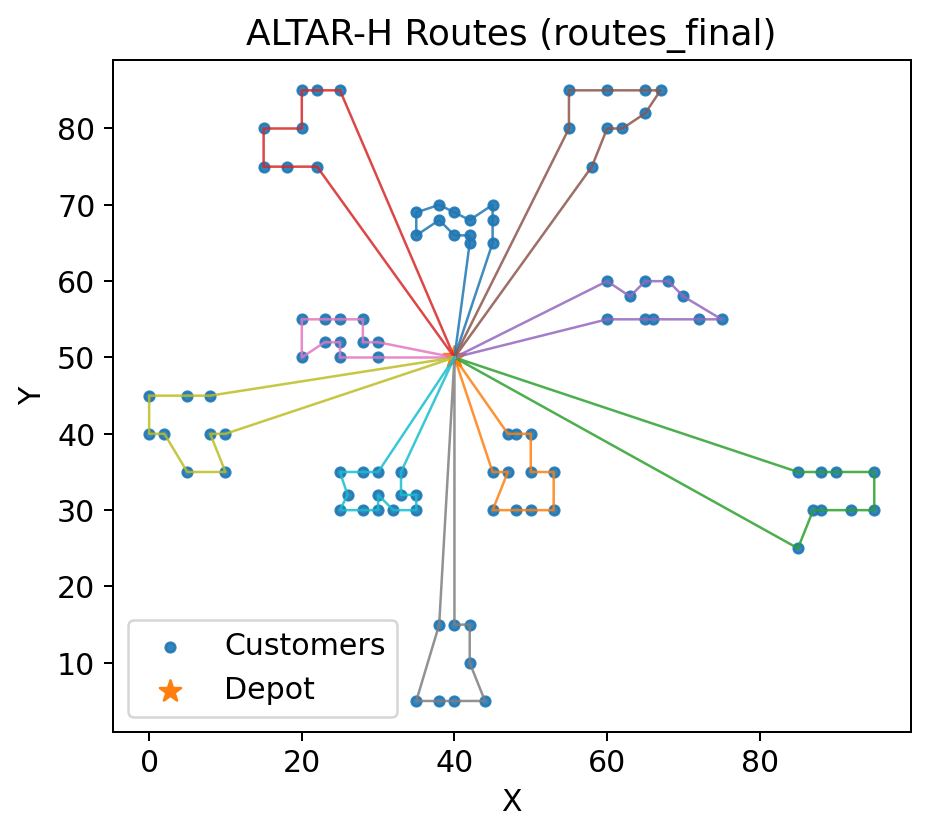

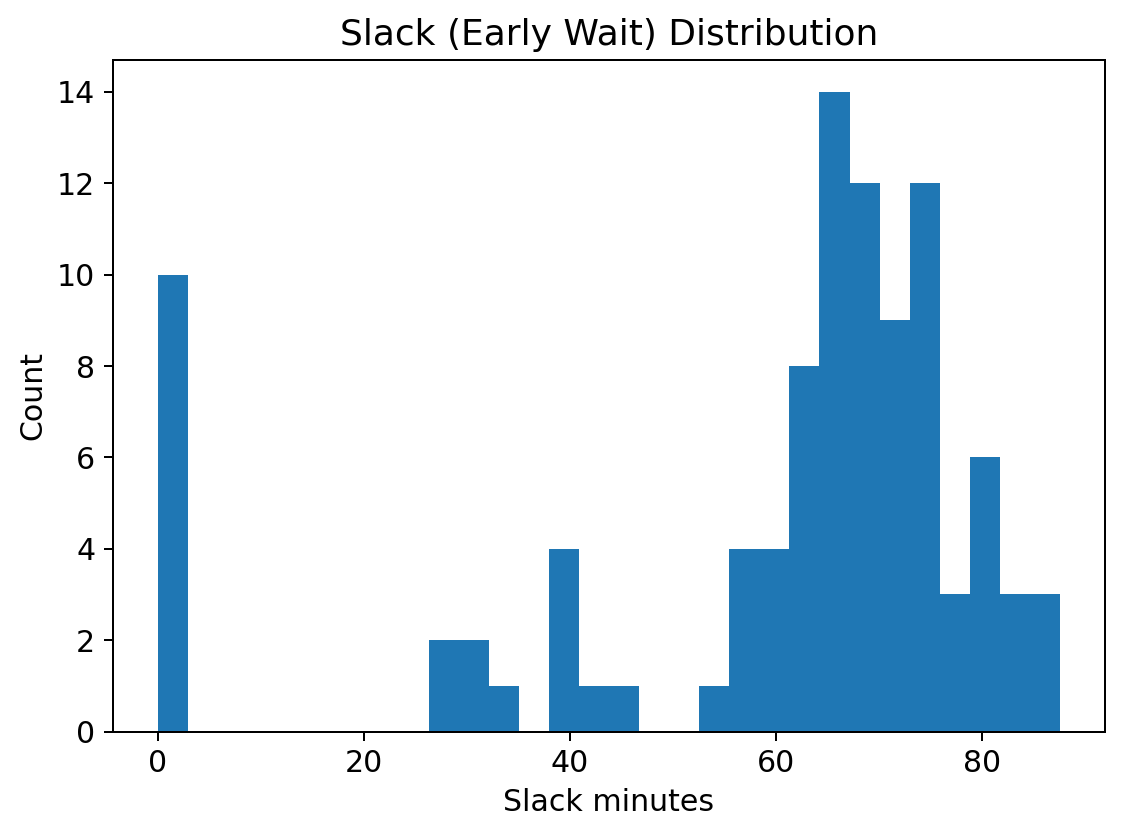

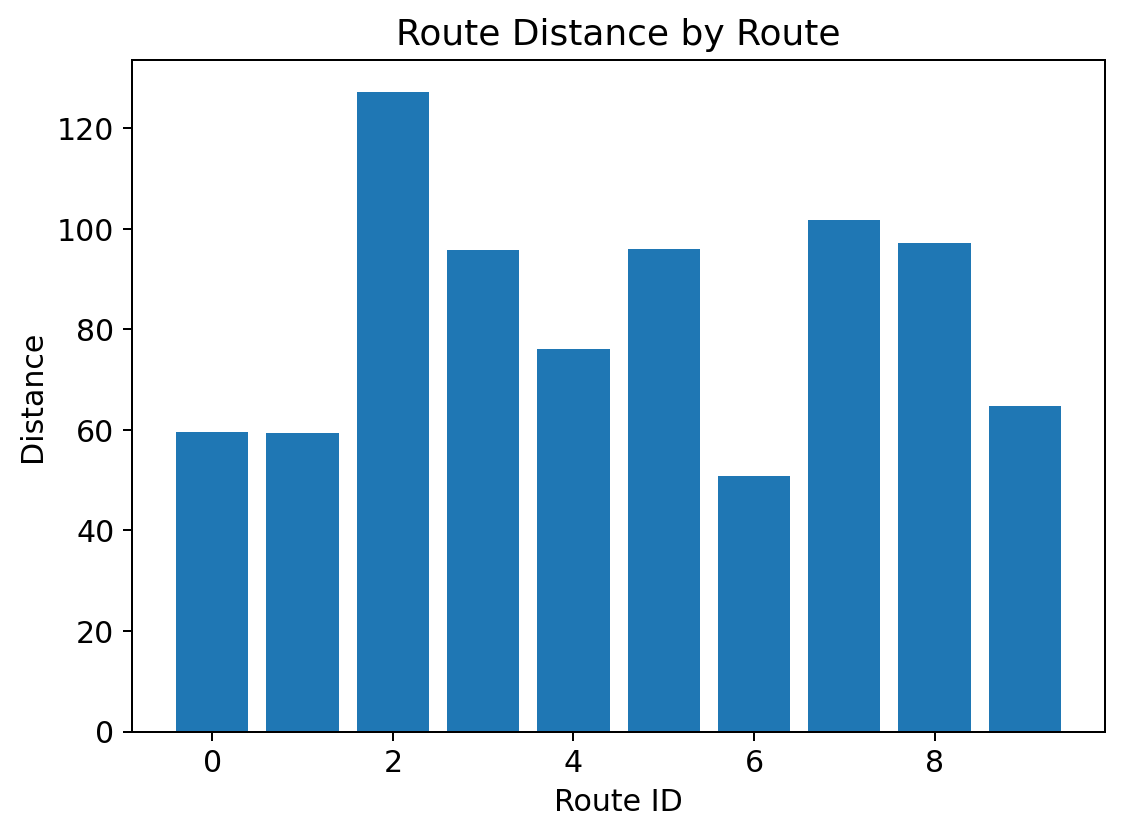

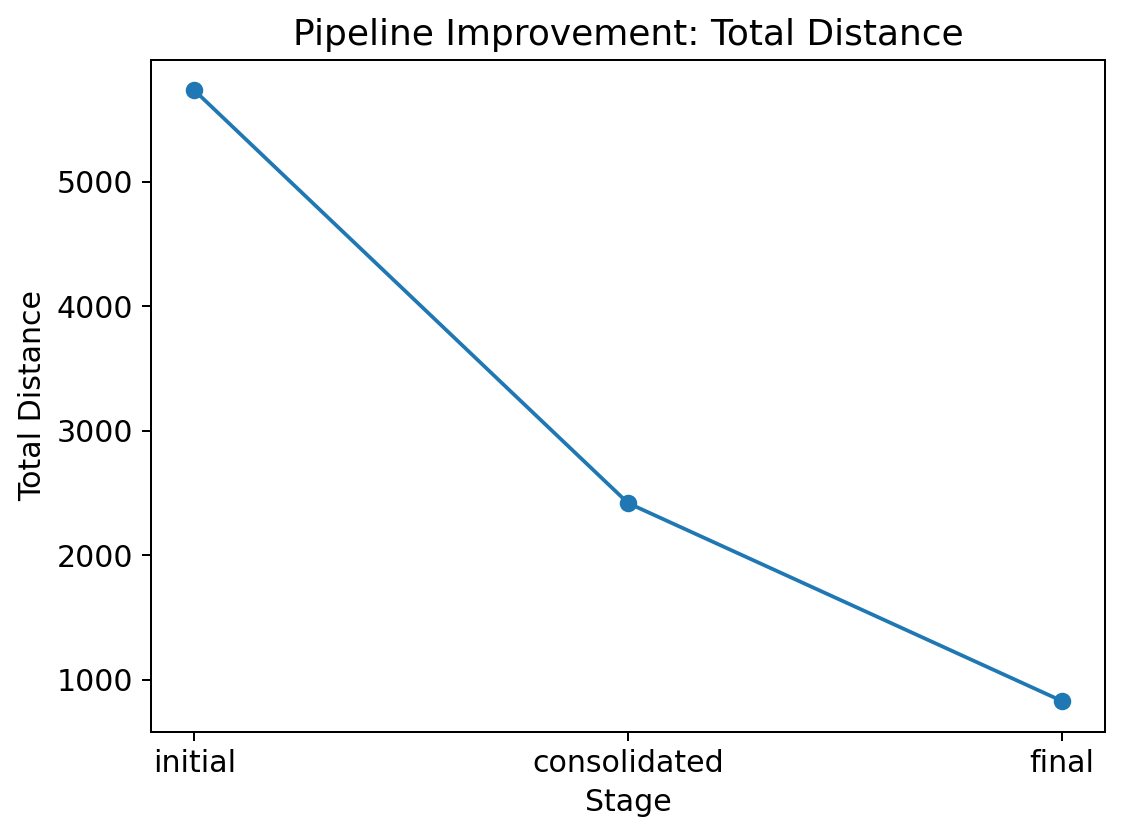

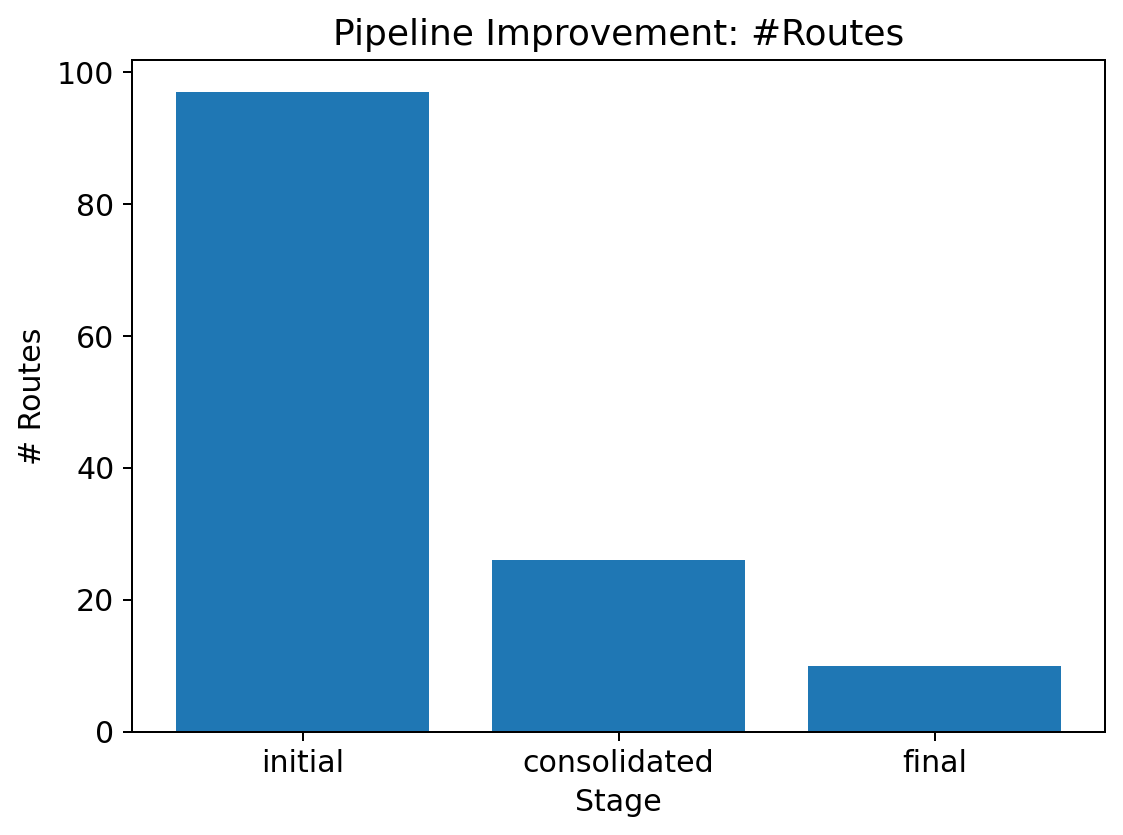


Saved figures in figures/: routes_map.png, slack_hist.png, route_distance_bar.png (+ pipeline_*.png if available)


In [ ]:
# C) Paper-ready plots
import json
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

Path("figures").mkdir(exist_ok=True)

# load best routes
for nm in ["routes_final.json","routes_consolidated.json","routes_initial.json"]:
    p = Path("outputs")/nm
    if p.exists():
        routes = json.loads(p.read_text()); source = nm.replace(".json",""); break
else:
    raise RuntimeError("No routes json found.")

depot = int(problem.depot_id)
coords = np.stack([problem.x, problem.y], axis=1)

def simulate_route_collect(route):
    cur, cur_arr = depot, float(problem.ready[depot])
    dist = 0.0; slacks = []; first_arr = None
    for j in route:
        info = earliest_arrival_with_wait(cur_arr, cur, j)
        if first_arr is None: first_arr = info["arrival"]
        dist += float(D[cur, j])
        slacks.append(float(info["early_wait"]))
        cur, cur_arr = j, info["arrival"] + float(problem.service[j])
    dist += float(D[cur, depot])
    return dist, slacks

# Route map
plt.figure(dpi=180)
for r in routes:
    xs = [coords[depot,0]] + [coords[j,0] for j in r] + [coords[depot,0]]
    ys = [coords[depot,1]] + [coords[j,1] for j in r] + [coords[depot,1]]
    plt.plot(xs, ys, linewidth=1, alpha=0.85)
plt.scatter(coords[1:,0], coords[1:,1], s=15, alpha=0.9, label="Customers")
plt.scatter([coords[depot,0]],[coords[depot,1]], s=80, marker="*", label="Depot")
plt.title(f"ALTAR-H Routes ({source})"); plt.xlabel("X"); plt.ylabel("Y"); plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout(); plt.savefig("figures/routes_map.png", dpi=300); plt.show()

# Slack histogram + route distance bar
all_slacks = []; route_dists = []
for r in routes:
    d, sl = simulate_route_collect(r)
    route_dists.append(d); all_slacks.extend(sl)

plt.figure(dpi=180); plt.hist(all_slacks, bins=30)
plt.title("Slack (Early Wait) Distribution"); plt.xlabel("Slack minutes"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("figures/slack_hist.png", dpi=300); plt.show()

plt.figure(dpi=180); plt.bar(range(len(route_dists)), route_dists)
plt.title("Route Distance by Route"); plt.xlabel("Route ID"); plt.ylabel("Distance")
plt.tight_layout(); plt.savefig("figures/route_distance_bar.png", dpi=300); plt.show()

# Pipeline improvement (if summaries exist)
stages, distances, routes_ct = [], [], []
def maybe_add(label, path):
    p = Path(path)
    if p.exists():
        s = json.loads(p.read_text())
        stages.append(label); distances.append(float(s["total_distance"])); routes_ct.append(int(s["num_routes"]))
maybe_add("initial", "outputs/routes_initial_summary.json")
maybe_add("consolidated", "outputs/routes_consolidated_summary.json")
maybe_add("final", "outputs/kpis_final.json")

if stages:
    plt.figure(dpi=180); plt.plot(stages, distances, marker="o")
    plt.title("Pipeline Improvement: Total Distance"); plt.xlabel("Stage"); plt.ylabel("Total Distance")
    plt.tight_layout(); plt.savefig("figures/pipeline_distance.png", dpi=300); plt.show()

    plt.figure(dpi=180); plt.bar(stages, routes_ct)
    plt.title("Pipeline Improvement: #Routes"); plt.xlabel("Stage"); plt.ylabel("# Routes")
    plt.tight_layout(); plt.savefig("figures/pipeline_routes.png", dpi=300); plt.show()

print("\nSaved figures in figures/: routes_map.png, slack_hist.png, route_distance_bar.png (+ pipeline_*.png if available)")


In [ ]:
# D) Paper tables
import json
import numpy as np
import pandas as pd
from pathlib import Path

for nm in ["routes_final.json","routes_consolidated.json","routes_initial.json"]:
    p = Path("outputs")/nm
    if p.exists():
        routes = json.loads(p.read_text()); source = nm; break
else:
    raise RuntimeError("No routes json found.")

depot = int(problem.depot_id)

def eval_for_tables(routes):
    rows_route, rows_stop = [], []
    total_dist = total_late = 0.0; late_cnt = 0
    for ridx, r in enumerate(routes):
        cur, cur_arr = depot, float(problem.ready[depot])
        load = 0.0; dist = 0.0; late_route = 0; tot_late_route = 0.0
        slacks = []
        for pos, j in enumerate(r):
            info = earliest_arrival_with_wait(cur_arr, cur, j)
            dist += float(D[cur, j]); load += float(problem.demand[j])
            lt = float(info["lateness"]); slacks.append(float(info["early_wait"]))
            if lt > 1e-6: late_route += 1; tot_late_route += lt
            rows_stop.append({
                "route_id": ridx, "position": pos+1, "node_id": int(j),
                "arrival": info["arrival"], "depart": info["arrival"] + float(problem.service[j]),
                "early_wait": info["early_wait"], "lateness": lt, "demand": int(problem.demand[j])
            })
            cur, cur_arr = j, info["arrival"] + float(problem.service[j])
        dist += float(D[cur, depot]); total_dist += dist; total_late += tot_late_route; late_cnt += late_route
        rows_route.append({
            "route_id": ridx, "num_stops": len(r), "total_demand": load,
            "total_distance": dist, "mean_slack": float(np.mean(slacks)) if slacks else 0.0,
            "num_late": late_route, "total_lateness": tot_late_route
        })
    kpis = {
        "num_routes": len(routes), "total_distance": round(total_dist,2),
        "num_late_stops": int(late_cnt), "total_lateness": round(total_late,2),
        "source": source
    }
    return kpis, pd.DataFrame(rows_route), pd.DataFrame(rows_stop)

kpis, df_route, df_stop = eval_for_tables(routes)

Path("outputs").mkdir(exist_ok=True)
df_route.to_csv("outputs/table_routes.csv", index=False)
df_stop.to_csv("outputs/table_stops.csv", index=False)

# Simple LaTeX bodies
latex_routes = df_route.copy()
latex_routes["total_distance"] = latex_routes["total_distance"].round(2)
latex_routes["mean_slack"] = latex_routes["mean_slack"].round(2)
routes_tex = latex_routes.to_latex(index=False, float_format="%.2f", longtable=False, escape=True)

kpis_df = pd.DataFrame([kpis])
kpis_tex = kpis_df.to_latex(index=False, escape=True)

(Path("outputs")/"table_routes.tex").write_text(routes_tex)
(Path("outputs")/"table_kpis.tex").write_text(kpis_tex)

print("Saved tables:")
print(" - outputs/table_routes.csv  &  outputs/table_routes.tex")
print(" - outputs/table_stops.csv")
print(" - outputs/table_kpis.tex")


Saved tables:
 - outputs/table_routes.csv  &  outputs/table_routes.tex
 - outputs/table_stops.csv
 - outputs/table_kpis.tex


In [ ]:
# OR-Tools baseline (VRPTW with capacity & time windows, CPU-only)

!pip -q install ortools

from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np, json
from pathlib import Path

depot = int(problem.depot_id)
n = problem.n
coords = np.stack([problem.x, problem.y], axis=1).astype(float)
dem = np.array(problem.demand, dtype=int)
ready = np.array(problem.ready, dtype=float)
due   = np.array(problem.due, dtype=float)
service = np.array(problem.service, dtype=float)

# Travel time = Euclidean distance (same units as earlier code)
dist = np.linalg.norm(coords[:,None,:]-coords[None,:,:], axis=2)

max_vehicles = int(getattr(problem, "max_vehicles", 30))  # 25 for c101
cap = int(problem.capacity)

# Manager & model
manager = pywrapcp.RoutingIndexManager(n, max_vehicles, depot)
routing = pywrapcp.RoutingModel(manager)

# Distance callback
def dist_cb(from_index, to_index):
    i = manager.IndexToNode(from_index); j = manager.IndexToNode(to_index)
    return int(round(dist[i,j]))
transit_cb_idx = routing.RegisterTransitCallback(dist_cb)
routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

# Time dimension = travel + service
def time_cb(from_index, to_index):
    i = manager.IndexToNode(from_index); j = manager.IndexToNode(to_index)
    return int(round(dist[i,j] + service[i]))
time_cb_idx = routing.RegisterTransitCallback(time_cb)

horizon = int(max(due) + 2*max(service))
routing.AddDimension(
    time_cb_idx,
    slack_max=0,              # no waiting modeled as slack; time windows enforce arrival
    capacity=horizon,
    fix_start_cumul_to_zero=True,
    name="Time",
)
time_dim = routing.GetDimensionOrDie("Time")

# Apply time windows at nodes (arrival must be within [ready, due])
for i in range(n):
    idx = manager.NodeToIndex(i)
    time_dim.CumulVar(idx).SetRange(int(ready[i]), int(due[i]))

# Capacity dimension
def demand_cb(from_index):
    i = manager.IndexToNode(from_index); return int(dem[i])
demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_cb)
routing.AddDimensionWithVehicleCapacity(
    demand_cb_idx, 0, [cap]*max_vehicles, True, "Capacity"
)

# Encourage fewer vehicles via a fixed cost
routing.SetFixedCostOfAllVehicles(100000)  # large fixed cost => fewer vehicles first

# Search params
params = pywrapcp.DefaultRoutingSearchParameters()
params.time_limit.FromSeconds(60)          # 60s CPU
params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH

solution = routing.SolveWithParameters(params)

routes_ort = []
if solution:
    for v in range(max_vehicles):
        idx = routing.Start(v)
        if routing.IsEnd(idx): continue
        route = []
        while not routing.IsEnd(idx):
            node = manager.IndexToNode(idx)
            nxt = solution.Value(routing.NextVar(idx))
            if routing.IsEnd(nxt): break
            node_n = manager.IndexToNode(nxt)
            route.append(node_n)
            idx = nxt
        if route: routes_ort.append(route)

    # KPIs
    def route_dist(r):
        cur = depot; d=0.0
        for j in r: d += float(dist[cur,j]); cur=j
        d += float(dist[cur,depot]); return d
    td = sum(route_dist(r) for r in routes_ort)
    kpis = {"num_routes": len(routes_ort), "total_distance": round(td,2)}

    Path("outputs").mkdir(exist_ok=True)
    (Path("outputs")/"routes_ortools.json").write_text(json.dumps(routes_ort))
    (Path("outputs")/"kpis_ortools.json").write_text(json.dumps(kpis, indent=2))
    print("OR-Tools:", kpis)
else:
    print("OR-Tools did not find a solution in time.")


OR-Tools did not find a solution in time.


In [ ]:
# E) Repro pack & ZIPs
import json, shutil
from pathlib import Path

Path("paper_figures").mkdir(exist_ok=True)
for f in ["routes_map.png","slack_hist.png","route_distance_bar.png","pipeline_distance.png","pipeline_routes.png"]:
    p = Path("figures")/f
    if p.exists(): shutil.copy(p, Path("paper_figures")/f)

cfg = {
    "capacity": int(problem.capacity),
    "max_vehicles": int(getattr(problem, "max_vehicles", 9999)),
    "service_time_non_depot": float(getattr(problem, "service_non_depot", 90.0)) if hasattr(problem,"service_non_depot") else 90.0,
    "apca": {"gamma": 0.15, "kappa_next": 0.08, "kappa_close": 0.12, "eta": 0.005},
    "knn_K": 10,
    "seeds": [7,42,99]
}
Path("outputs").mkdir(exist_ok=True)
(Path("outputs")/"config.json").write_text(json.dumps(cfg, indent=2))

# Bundle outputs and figures
shutil.make_archive("/content/altarh_outputs", "zip", "/content", base_dir="outputs")
shutil.make_archive("/content/altarh_figures", "zip", "/content", base_dir="figures")

print("Created:")
print(" - outputs/config.json")
print(" - /content/altarh_outputs.zip")
print(" - /content/altarh_figures.zip")


Created:
 - outputs/config.json
 - /content/altarh_outputs.zip
 - /content/altarh_figures.zip
